In [1]:
%matplotlib inline

In [2]:
# !pip freeze > requirements.txt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
import re
import os 

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import networkx as nx
from networkx.algorithms import community

import time
from datetime import datetime

import requests
import PyPDF2
from wordcloud import WordCloud

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
# nltk.download('stopwords')

In [5]:
def create_graph_for_country_refugee(filtered_data, year=2022, refugees_treshhold=10_000):
    """
    Function tha creates a visual graph to represent refugee movements from a given country of origin to 
    asylum countries during a specific year.
    The graph will only display connections between countries where the number of refugees.
    
    Parameters:
    ----------
    dataset : DataFrame
        The dataset to process.
    year : int, optional (default=2022)
        The year of interest for processing.
    refugees_threshold : int, optional (default=10,000)
        The minimum number of refugees to consider in the analysis.
    """    
    filtered_data = filtered_data[filtered_data["Year"] == year]

    refugee_graph = nx.Graph()
    
    country_of_origin = filtered_data["Country of origin (ISO)"].unique()[0]

    group_by_aslym_country = filtered_data.groupby('Country of asylum (ISO)')["Refugees under UNHCR's mandate"].sum()
    
    for country, count in group_by_aslym_country.items():
        if (count >= refugees_treshhold):
            refugee_graph.add_edge(country_of_origin, country, weight=count)
          
    plt.figure(figsize=(16, 16))
    pos = nx.circular_layout(refugee_graph)
    country_full_name = filtered_data[filtered_data["Country of origin (ISO)"] == country_of_origin]["Country of origin"].iloc[0]

    node_sizes = []
    for node in refugee_graph.nodes():
        neighbors = list(refugee_graph.neighbors(node))
        weight_sum = sum(refugee_graph[node][neighbor]['weight'] for neighbor in neighbors)
        if weight_sum >= 1_000_000:
            node_sizes.append(2000)
        elif 100_000 <= weight_sum < 1_000_000:
            node_sizes.append(1000)
        elif 10_000 <= weight_sum < 100_000:
            node_sizes.append(100)
        else:
            node_sizes.append(10)

    nx.draw_networkx(refugee_graph, pos, with_labels=True,arrows=True,node_size=node_sizes)
    
    edge_labels = nx.get_edge_attributes(refugee_graph, 'weight')
    nx.draw_networkx_edge_labels(refugee_graph, pos, edge_labels=edge_labels)
    
    plt.gca().set_aspect("equal")
    plt.title(f'Graph ({year})\nRefugee movement from {country_full_name}')
    plt.show()
    return


In [6]:
def create_map_for_country_refugee(filtered_data, year=2022, refugees_treshhold=10_000):
    """
    Function that displays a map of countries that have received a significant number of refugees 
    from a specified country of origin in a given year.
    
    Parameters:
    ----------
    dataset : DataFrame
        The dataset to process.
    year : int, optional (default=2022)
        The year of interest for processing.
    refugees_threshold : int, optional (default=10,000)
        The minimum number of refugees to consider in the analysis.
    """
    filtered_data = filtered_data[filtered_data["Year"] == year]
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    country_of_origin = filtered_data["Country of origin (ISO)"].unique()[0]
    countries = []
    group_by_aslym_country = filtered_data.groupby('Country of asylum (ISO)')["Refugees under UNHCR's mandate"].sum()
    
    for country, count in group_by_aslym_country.items():
        if (count >= refugees_treshhold):
            countries.append(country)
    
    country_map = world[world['iso_a3'] == country_of_origin]
    countries_map = world[world['iso_a3'].isin(countries)]
    
    country_full_name = filtered_data[filtered_data["Country of origin (ISO)"] == country_of_origin]["Country of origin"].iloc[0]
    
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_facecolor('lightblue')
    world.plot(ax=ax, color='green')
    country_map.plot(ax=ax, color="red")
    countries_map.plot(ax=ax, color="orange")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Map for ({year})\n{len(countries)} countries with more than {refugees_treshhold} relocated refugees from {country_full_name}')
    plt.show()
    return


In [7]:
def create_graph_for_country_aslym(filtered_data, year=2022, refugees_treshhold=10_000):
    """
    Function tha creates a visual graph for refugee inflow to a given asylum country during a specific year.
    The graph will only display connections between countries where the number of refugees.
    
    Parameters:
    ----------
    dataset : DataFrame
        The dataset to process.
    year : int, optional (default=2022)
        The year of interest for processing.
    refugees_threshold : int, optional (default=10,000)
        The minimum number of refugees to consider in the analysis.
    """
    filtered_data = filtered_data[filtered_data["Year"] == year]

    refugee_graph = nx.Graph()
    
    country_of_origin = filtered_data["Country of asylum (ISO)"].unique()[0]

    group_by_aslym_country = filtered_data.groupby('Country of origin (ISO)')["Refugees under UNHCR's mandate"].sum()
    
    for country, count in group_by_aslym_country.items():
        if (count >= refugees_treshhold):
            refugee_graph.add_edge(country_of_origin, country, weight=count)
          
    plt.figure(figsize=(16, 16))
    pos = nx.circular_layout(refugee_graph)
    country_full_name = filtered_data[filtered_data["Country of asylum (ISO)"] == country_of_origin]["Country of asylum"].iloc[0]

    node_sizes = []
    for node in refugee_graph.nodes():
        neighbors = list(refugee_graph.neighbors(node))
        weight_sum = sum(refugee_graph[node][neighbor]['weight'] for neighbor in neighbors)
        if weight_sum >= 1_000_000:
            node_sizes.append(2000)
        elif 100_000 <= weight_sum < 1_000_000:
            node_sizes.append(1000)
        elif 10_000 <= weight_sum < 100_000:
            node_sizes.append(100)
        else:
            node_sizes.append(10)
    
    nx.draw_networkx(refugee_graph, pos, with_labels=True,arrows=True,node_size=node_sizes)
    
    edge_labels = nx.get_edge_attributes(refugee_graph, 'weight')
    nx.draw_networkx_edge_labels(refugee_graph, pos, edge_labels=edge_labels)
    
    plt.gca().set_aspect("equal")
    plt.title(f'Graph ({year})\nRefugee movement in {country_full_name}')
    plt.show()
    return


In [8]:
def create_map_for_country_aslym(filtered_data, year=2022, refugees_treshhold=10_000):
    """
    Function that displays a map of countries that have received a significant number of refugees 
    from a specified country of origin in a given year.

    Parameters:
    ----------
    dataset : DataFrame
        The dataset to process.
    year : int, optional (default=2022)
        The year of interest for processing.
    refugees_threshold : int, optional (default=10,000)
        The minimum number of refugees to consider in the analysis.
    """
    filtered_data = filtered_data[filtered_data["Year"] == year]
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    country_of_origin = filtered_data["Country of asylum (ISO)"].unique()[0]
    countries = []
    group_by_aslym_country = filtered_data.groupby('Country of origin (ISO)')["Refugees under UNHCR's mandate"].sum()
    
    for country, count in group_by_aslym_country.items():
        if (count >= refugees_treshhold):
            countries.append(country)
    
    country_map = world[world['iso_a3'] == country_of_origin]
    countries_map = world[world['iso_a3'].isin(countries)]
    
    country_full_name = filtered_data[filtered_data["Country of asylum (ISO)"] == country_of_origin]["Country of asylum"].iloc[0]
    
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_facecolor('lightblue')
    world.plot(ax=ax, color='green')
    country_map.plot(ax=ax, color="blue")
    countries_map.plot(ax=ax, color="orange")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Map for ({year})\n{len(countries)} countries with more than {refugees_treshhold} refugees in {country_full_name}')
    plt.show()
    return


### Abstract

In this article, readers will gain a clear understanding of key terminology associated with UNHCR. It offers insights into current refugee flow trends due to global conflicts. Encouraging interactive research, readers are prompted to explore refugee situations and countries of asylum further. The article also delves into the refugee trends within the European Union, especially the influence of the Russo-Ukrainian war. Conclusions will be drawn based on UNHCR reports from 2021 and 2022.

# Wars and refugee flows (2018-2022) 

Every day we heard, "We live in the most peaceful times in human history". The news talked about wars, but they somehow remained separate from us with the rest of the information flow. There was talks about refugees and migrants and they are people no different from us, but we didn't pay much attention.

However, when the conflict that led Russia and Ukraine into war, made us think more seriously about these issues. That's why in this article, we will explore, investigate, analyze, and make conclusions on the topic: "Wars and refugee flows (2018-2022)".

To begin, we need to explain some key terms that will be part of our article.

#### What is war?
War is a state of prolonged, large-scale conflict involving regular or irregular armed forces, often between nations or groups in nation. War can result in significant social, economic, and political disruption, including the loss of life and extensive property damage.

#### What is refugees?
Under international law, a refugee is someone who is forced to flee their home country to escape persecution or a serious threat to their life, physical integrity or freedom. This may be linked to their race, religion, nationality, political beliefs or membership of a social group. But also to situations of conflict, violence or public disorder. Refugees are protected by international law and cannot be sent back home if their life or freedom would be at risk.

#### What is asylum?

Asylum is a protection granted to foreign nationals already in the United States or arriving at the border who meet the international law definition of a "refugee." The United Nations 1951 Convention and 1967 Protocol define a refugee as a person who is unable or unwilling to return to his or her home country, and cannot obtain protection in that country, due to past persecution or a well-founded fear of being persecuted in the future “on account of race, religion, nationality, membership in a particular social group, or political opinion.”

#### What is UNHCR?

United Nations High Commissioner for Refugees (UNHCR) is a United Nations agency mandated to aid and protect refugees, forcibly displaced communities, and stateless people, and to assist in their voluntary repatriation, local integration or resettlement to a third country. It is headquartered in Geneva, Switzerland.


####  What is the difference between refugees and migrants?

Refugees are defined and protected in international law. Refugees are people outside their country of origin because of feared persecution, conflict, violence, or other circumstances that have seriously disturbed public order, and who, as a result, require ‘international protection’.

The term ‘migrant’, on the other hand, is not defined under international law and is sometimes used differently by different stakeholders. Traditionally, the word ‘migrant’ has been used to designate people who move by choice rather than to escape conflict or persecution, usually across an international border. This can include finding work or pursuing an education, but also for reuniting with family or other reasons. People may also move to alleviate significant hardships that arise from natural disasters, famine, or extreme poverty. Those who leave their countries for these reasons would not usually be considered refugees under international law.

For future questions and terminology, you can visit [UNHCR FAQs](https://www.unhcr.org/contact-us/frequently-asked-questions).



## I. Wars

On [this Wikipedia](https://en.wikipedia.org/wiki/List_of_wars:_2003%E2%80%93present) page, we see a list of ongoing wars from 2003 to the present. They are separated into three tables: 2003-2009, 2010-2019, and 2020-present. We will combine all of them into one dataset.

In [9]:
url = "https://en.wikipedia.org/wiki/List_of_wars:_2003%E2%80%93present"
tables = pd.read_html(url, header=0)

wars_df_before_2009 = tables[0]

file_path = os.path.join("data/ongoing_wars", "ongoing_wars_before_2009.csv")
wars_df_before_2009.to_csv(file_path, index=False)

In [10]:
ongoing_wars_before_2009 = pd.read_csv("data/ongoing_wars/ongoing_wars_before_2009.csv", skiprows=2)
ongoing_wars_before_2009.columns = ["Started", "Ended", "Name_of_conflict", "Belligerents_1", "Belligerents_2"]
ongoing_wars_before_2009.shape

(44, 5)

In [11]:
url = "https://en.wikipedia.org/wiki/List_of_wars:_2003%E2%80%93present"
tables = pd.read_html(url, header=0)

wars_df_after_2009 = tables[1]

file_path = os.path.join("data/ongoing_wars", "ongoing_wars_after_2009.csv")
wars_df_after_2009.to_csv(file_path, index=False)

In [12]:
ongoing_wars_after_2009 = pd.read_csv("data/ongoing_wars/ongoing_wars_after_2009.csv", skiprows=2)
ongoing_wars_after_2009.columns = ["Started", "Ended", "Name_of_conflict", "Belligerents_1", "Belligerents_2"]
ongoing_wars_after_2009.shape

(56, 5)

In [13]:
url = "https://en.wikipedia.org/wiki/List_of_wars:_2003%E2%80%93present"
tables = pd.read_html(url, header=0)

wars_df_after_2020 = tables[2]

file_path = os.path.join("data/ongoing_wars", "ongoing_wars_after_2020.csv")
wars_df_after_2020.to_csv(file_path, index=False)

In [14]:
ongoing_wars_after_2020 = pd.read_csv("data/ongoing_wars/ongoing_wars_after_2020.csv", skiprows=2)
ongoing_wars_after_2020.columns = ["Started", "Ended", "Name_of_conflict", "Belligerents_1", "Belligerents_2"]
ongoing_wars_after_2020.shape

(22, 5)

In [15]:
ongoing_wars = pd.concat([ongoing_wars_before_2009, ongoing_wars_after_2009, ongoing_wars_after_2020])
print(ongoing_wars.shape)
ongoing_wars.head()

(122, 5)


Started    Ended                                   Name_of_conflict  \
0     2003     2011                Iraq War Part of the Iraqi conflict   
1     2004     2010  Sinaloa Cartel–Gulf Cartel conflict Part of th...   
2     2004  Ongoing                          South Thailand insurgency   
3     2004  Ongoing                   Insurgency in Khyber Pakhtunkhwa   
4     2004  Ongoing  Iran–PJAK conflict Part of the Kurdish separat...   

                                      Belligerents_1  \
0  Invasion phase (2003)  United States  United K...   
1                                     Sinaloa Cartel   
2                                           Thailand   
3            Pakistan  United States  United Kingdom   
4                         Iran Supported by:  Turkey   

                                      Belligerents_2  
0  Invasion phase (2003)  Iraq Post-invasion (200...  
1                                        Gulf Cartel  
2  National Revolution Front (BRN)  Runda Kumpula...  
3  Taliban-aligned groups  Tehrik-i-Taliban Pakis...  
4  Kurdistan Free Life Party Supported by:  Unite...

In [16]:
print(ongoing_wars.dtypes)

Started              int64
Ended               object
Name_of_conflict    object
Belligerents_1      object
Belligerents_2      object
dtype: object


In [17]:
ongoing_wars_droped_named = ongoing_wars.copy()
ongoing_wars_droped_named = ongoing_wars_droped_named[ongoing_wars_droped_named["Ended"].str.isnumeric()]
ongoing_wars_droped_named["Ended"] = ongoing_wars_droped_named["Ended"].astype(int)
ongoing_wars_droped_named = ongoing_wars_droped_named[ongoing_wars_droped_named["Ended"] >= 2018]
print(ongoing_wars_droped_named.shape)
ongoing_wars_droped_named.head()

(25, 5)


Started  Ended                                   Name_of_conflict  \
7      2011   2020  Sudanese conflict in South Kordofan and Blue Nile   
20     2013   2020  Batwa–Luba clashes Part of the Katanga insurgency   
21     2013   2021                      RENAMO insurgency (2013–2021)   
23     2013   2020  South Sudanese Civil War Part of the ethnic vi...   
27     2014   2020                            Second Libyan Civil War   

                                       Belligerents_1  \
7                                               Sudan   
20                       Pygmy Batwa militias "Perci"   
21                                         Mozambique   
23  South Sudan  Mathiang Anyoor Maban Defence For...   
27  House of Representatives (Tobruk-based) Zintan...   

                                       Belligerents_2  
7   SRF  SPLM-N  SLA  JEM Alleged support:  Ethiop...  
20                           Luba militias "Elements"  
21                                             RENAMO  
23  SPLM-IO[110]  Nuer White Army  SSDM  Cobra Fac...  
27  Government of National Accord (Tripoli-based) ...

In [18]:
ongoing_wars_ongoing = ongoing_wars.copy()
ongoing_wars_ongoing = ongoing_wars_ongoing[(ongoing_wars_ongoing["Ended"] == "Ongoing")]
print(ongoing_wars_ongoing.shape)
ongoing_wars_ongoing.head()

(42, 5)


Started    Ended                                   Name_of_conflict  \
2     2004  Ongoing                          South Thailand insurgency   
3     2004  Ongoing                   Insurgency in Khyber Pakhtunkhwa   
4     2004  Ongoing  Iran–PJAK conflict Part of the Kurdish separat...   
5     2004  Ongoing                        Conflict in the Niger Delta   
9     2004  Ongoing  Sistan and Baluchestan insurgency Part of the ...   

                            Belligerents_1  \
2                                 Thailand   
3  Pakistan  United States  United Kingdom   
4               Iran Supported by:  Turkey   
5   Nigeria Supported by:  Belarus  Israel   
9                                     Iran   

                                      Belligerents_2  
2  National Revolution Front (BRN)  Runda Kumpula...  
3  Taliban-aligned groups  Tehrik-i-Taliban Pakis...  
4  Kurdistan Free Life Party Supported by:  Unite...  
5  Niger Delta Avengers (2016–present) Niger Delt...  
9  Jundallah (2004–11)  Harakat Ansar (2012–13)  ...

In [19]:
ongoing_wars_final = pd.concat([ongoing_wars_droped_named, ongoing_wars_ongoing])
print(ongoing_wars_final.shape)
ongoing_wars_final.head()

(67, 5)


Started Ended                                   Name_of_conflict  \
7      2011  2020  Sudanese conflict in South Kordofan and Blue Nile   
20     2013  2020  Batwa–Luba clashes Part of the Katanga insurgency   
21     2013  2021                      RENAMO insurgency (2013–2021)   
23     2013  2020  South Sudanese Civil War Part of the ethnic vi...   
27     2014  2020                            Second Libyan Civil War   

                                       Belligerents_1  \
7                                               Sudan   
20                       Pygmy Batwa militias "Perci"   
21                                         Mozambique   
23  South Sudan  Mathiang Anyoor Maban Defence For...   
27  House of Representatives (Tobruk-based) Zintan...   

                                       Belligerents_2  
7   SRF  SPLM-N  SLA  JEM Alleged support:  Ethiop...  
20                           Luba militias "Elements"  
21                                             RENAMO  
23  SPLM-IO[110]  Nuer White Army  SSDM  Cobra Fac...  
27  Government of National Accord (Tripoli-based) ...

In [20]:
ongoing_wars_ongoing = ongoing_wars_ongoing.reset_index()
ongoing_wars_ongoing = ongoing_wars_ongoing.drop(columns=["index"])
ongoing_wars_ongoing

Started    Ended                                   Name_of_conflict  \
0      2004  Ongoing                          South Thailand insurgency   
1      2004  Ongoing                   Insurgency in Khyber Pakhtunkhwa   
2      2004  Ongoing  Iran–PJAK conflict Part of the Kurdish separat...   
3      2004  Ongoing                        Conflict in the Niger Delta   
4      2004  Ongoing  Sistan and Baluchestan insurgency Part of the ...   
5      2005  Ongoing                             Insurgency in Paraguay   
6      2006  Ongoing                               Fatah–Hamas conflict   
7      2006  Ongoing                                   Mexican drug war   
8      2007  Ongoing                           Operation Juniper Shield   
9      2009  Ongoing  Somali Civil War (2009–present) Part of the So...   
10     2009  Ongoing                         Sudanese nomadic conflicts   
11     2009  Ongoing                              Boko Haram insurgency   
12     2009  Ongoing                             South Yemen insurgency   
13     2011  Ongoing                                   Sinai insurgency   
14     2011  Ongoing                         Shia insurgency in Bahrain   
15     2011  Ongoing                                   Syrian civil war   
16     2011  Ongoing  Ethnic violence in South Sudan (2011–present) ...   
17     2012  Ongoing                                           Mali War   
18     2012  Ongoing                 Central African Republic Civil War   
19     2014  Ongoing                      Russo-Ukrainian War (outline)   
20     2014  Ongoing                      War against the Islamic State   
21     2014  Ongoing                    Yemeni Civil War (2014–present)   
22     2015  Ongoing  Islamic State insurgency in Tunisia Part of th...   
23     2015  Ongoing  Kurdish–Turkish conflict (2015–present) Part o...   
24     2016  Ongoing  2016 Niger Delta conflict Part of the Conflict...   
25     2016  Ongoing  Conflict in Rakhine State Part of the Rohingya...   
26     2016  Ongoing                        Insurgency in Northern Chad   
27     2017  Ongoing                                  Anglophone Crisis   
28     2017  Ongoing                         Insurgency in Cabo Delgado   
29     2017  Ongoing  Islamic State insurgency in Iraq (2017–present...   
30     2018  Ongoing  Catatumbo campaign Part of the Colombian conflict   
31     2019  Ongoing  2019–2022 Persian Gulf crisis Part of the Iran...   
32     2020  Ongoing                         Western Togoland Rebellion   
33     2020  Ongoing  2020–2023 Western Saharan clashes Part of the ...   
34     2021  Ongoing  Insurgency in Southeastern Nigeria Part of the...   
35     2021  Ongoing  Myanmar civil war (2021–present) Part of the I...   
36     2021  Ongoing  2021–2023 Armenia–Azerbaijan border crisis Par...   
37     2021  Ongoing  Republican insurgency in Afghanistan Part of t...   
38     2022  Ongoing  Russian invasion of Ukraine Part of the Russo-...   
39     2023  Ongoing                             2023 Las Anod conflict   
40     2023  Ongoing  War in Amhara Part of the Ethiopian civil conf...   
41     2023  Ongoing                                2023 Sudan conflict   

                                       Belligerents_1  \
0                                            Thailand   
1             Pakistan  United States  United Kingdom   
2                          Iran Supported by:  Turkey   
3              Nigeria Supported by:  Belarus  Israel   
4                                                Iran   
5   Paraguay Supported by:  United States  Colombi...   
6                                               Hamas   
7   Mexico Self-defense groups Consulting and trai...   
8   Algeria  Morocco  Mauritania  Tunisia  Burkina...   
9   Somalia  United States  AMISOM Participants:  ...   
10                                     Various tribes   
11  Multinational Joint Task Force  Nigeria  Camer...   
12  Yemen Pro-government tribes  Al-I

In [21]:
print(f"There are {ongoing_wars_ongoing.shape[0]} ongoing conflicts as of {datetime.now().strftime('%Y-%m-%d')}.")

There are 42 ongoing conflicts as of 2023-08-18.


From this data, there are 42 armed conflicts around the world. This is a fact with which very few people are familiar.

When there are so many armed conflicts, it's logical that there will also be many casualties (unfortunately). 
On [this Wikipedia](https://en.wikipedia.org/wiki/List_of_ongoing_armed_conflicts) page, we find statistics on the victims.

In [22]:
deads_armed_conflicts = pd.read_csv("data/ongoing_wars/deads_in_armed_conflicts.csv")
deads_armed_conflicts.head(5)

Country_2018  Deaths_2018  Country_2019  Deaths_2019 Country_2020  \
0  Afghanistan        35941   Afghanistan        41735       Mexico   
1       Mexico        33341        Mexico        35588  Afghanistan   
2        Yemen        22201         Yemen        16050        Yemen   
3        Syria        20130         Syria        11244        Syria   
4         Iraq         4920  Saudi Arabia         4832      Nigeria   

   Deaths_2020 Country_2021  Deaths_2021 Country_2022  Deaths_2022  
0        34512  Afghanistan        42223      Ukraine       240400  
1        20674        Yemen        31048     Ethiopia       105900  
2        19561     Ethiopia        22800      Myanmar        20206  
3         7620       Mexico        18811       Mexico         7821  
4         7172      Myanmar        11114        Yemen         6607

In [23]:
deads_armed_conflicts_2018_2022 = {}
for year in range(2018, 2023):
    country_col = f"Country_{year}"
    deads_col = f"Deaths_{year}"

    for index, row in deads_armed_conflicts.iterrows():
        country = row[country_col]
        deads = int(row[deads_col])

        if country not in deads_armed_conflicts_2018_2022:
            deads_armed_conflicts_2018_2022[country] = 0

        deads_armed_conflicts_2018_2022[country] += deads

deads_armed_conflicts_2018_2022_data = pd.DataFrame(list(deads_armed_conflicts_2018_2022.items()), columns=['Country', 'Deaths'])
deads_armed_conflicts_2018_2022_data = deads_armed_conflicts_2018_2022_data.sort_values(by="Deaths", ascending=False)
deads_armed_conflicts_2018_2022_data = deads_armed_conflicts_2018_2022_data.reset_index()
deads_armed_conflicts_2018_2022_data = deads_armed_conflicts_2018_2022_data.drop(columns = "index")

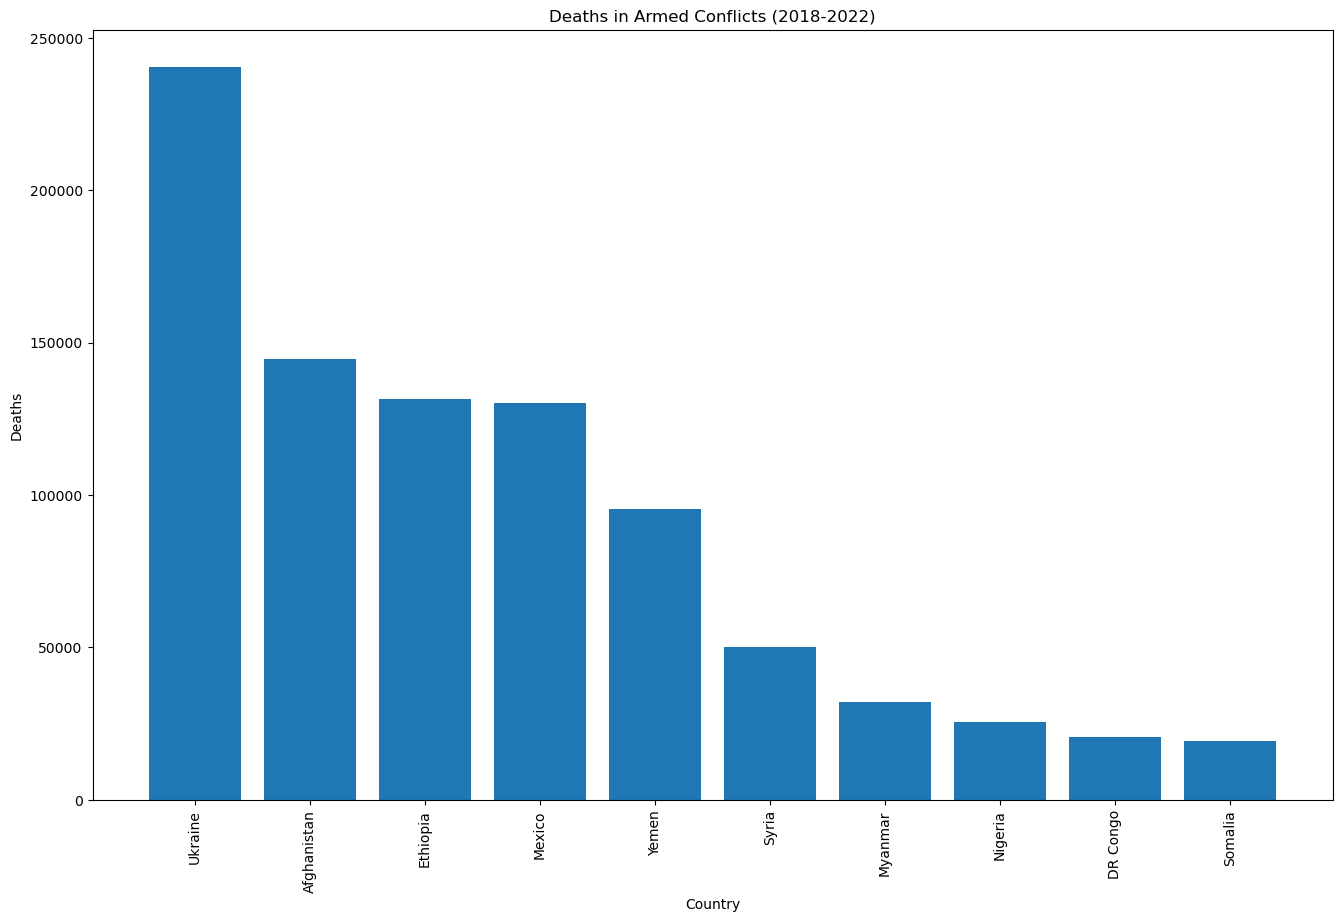

In [24]:
deads_armed_conflicts_2018_2022_data_first_ten = deads_armed_conflicts_2018_2022_data[:10]

plt.figure(figsize=(16, 10)) 

plt.bar(deads_armed_conflicts_2018_2022_data_first_ten['Country'], deads_armed_conflicts_2018_2022_data_first_ten['Deaths'])

plt.xlabel('Country')
plt.ylabel('Deaths')
plt.title('Deaths in Armed Conflicts (2018-2022)')
plt.xticks(rotation=90) 

plt.show()


As we can see, the majority of casualties in this statistic are from Ukraine, they are from the last year when, on 24 February 2022, Russia invaded Ukraine.

We will melt the dataset with ongoing wars, and based on the arrangement on the Wikipedia page "Belligerents_1" and "Belligerents_2" represents the countries involved in the conflict.

In [25]:
ongoing_wars_ongoing_melted = ongoing_wars_ongoing.copy()
ongoing_wars_ongoing_melted = ongoing_wars_ongoing_melted.melt(id_vars=["Belligerents_1", "Belligerents_2"], 
                                                    value_vars=["Name_of_conflict"],
                                                    value_name="Name_of_conflict")

ongoing_wars_ongoing_melted.drop(columns="variable", inplace=True)
ongoing_wars_ongoing_melted

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\3943661703.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  ongoing_wars_ongoing_melted = ongoing_wars_ongoing_melted.melt(id_vars=["Belligerents_1", "Belligerents_2"],


Belligerents_1  \
0                                            Thailand   
1             Pakistan  United States  United Kingdom   
2                          Iran Supported by:  Turkey   
3              Nigeria Supported by:  Belarus  Israel   
4                                                Iran   
5   Paraguay Supported by:  United States  Colombi...   
6                                               Hamas   
7   Mexico Self-defense groups Consulting and trai...   
8   Algeria  Morocco  Mauritania  Tunisia  Burkina...   
9   Somalia  United States  AMISOM Participants:  ...   
10                                     Various tribes   
11  Multinational Joint Task Force  Nigeria  Camer...   
12  Yemen Pro-government tribes  Al-Islah militias...   
13                Egypt  Israel  United Arab Emirates   
14                                            Bahrain   
15  Syrian Arab Republic  Hezbollah  Iran  Russia ...   
16                                     Various tribes   
17  Government of Mali  France  Turkey  ECOWAS ful...   
18  Central African Republic  MINUSCA (since 2014)...   
19  Russia  Donetsk People's Republic  Luhansk Peo...   
20  Intervening in Syria and Iraq:  CJTF–OIR Suppo...   
21  Supreme Political Council  Houthis  Pro-Saleh ...   
22  Islamic State (ISIL) Wilayat Tarabulus Wilayah...   
23                                             Turkey   
24                                            Nigeria   
25                                            Myanmar   
26                                   Chad  France JEM   
27                                           Cameroon   
28  Mozambique  Rwanda (from 2021) Supported by:  ...   
29  Iraq  Pro-Government Tribes Rojava (cross-bord...   
30                                           Colombia   
31  United States  CJTF–OIR  International Maritim...   
32                                              Ghana   
33                                            Morocco   
34                                               IPOB   
35  State Administration Council  Tatmadaw  Border...   
36                                            Armenia   
37                     Islamic Emirate of Afghanistan   
38  Ukraine Ukrainian diaspora volunteers Foreign ...   
39               Somaliland  Somaliland National Army   
40                 Fano militia  Amhara Special Force   
41     Transitional Sovereignty Council  Armed Forces   

                                       Belligerents_2  \
0   National Revolution Front (BRN)  Runda Kumpula...   
1   Taliban-aligned groups  Tehrik-i-Taliban Pakis...   
2   Kurdistan Free Life Party Supported by:  Unite...   
3   Niger Delta Avengers (2016–present) Niger Delt...   
4   Jundallah (2004–11)  Harakat Ansar (2012–13)  ...   
5   Paraguayan People's Army (EPP)  Armed Peasant ...   
6   Fatah Supported by:  United States (allegedly)...   
7   Cartels:  Sinaloa Cartel  Gulf Cartel Los Metr...   
8   al-Qaeda (2007–present)  Ansar Dine (2012–17) ...   
9   Al-Qaeda  Al-Shabaab Foreign mujahideen  Hizbu...   
10                                     Various tribes   
11  Boko Haram  Islamic State's West Africa Provin...   
12  Southern Transitional Council (since 2017) Sou...   
13  Islamists: Ansar Bait al-Maqdis  Al-Qaeda Tawh...   
14  Al-Ashtar Brigades Wa'ad Allah Brigades Islami...   
15  Syrian Interim Government (Syrian opposition) ...   
16                                     Various tribes   
17  National Movement for the Liberation of Azawad...   
18  FPRC  UPC  MPC  3R  Séléka CPJP CPSK UFDR FDPC...   
19  Ukraine Supported by:  NATO[d][124]  European ...   
20  Islamic State  Boko Haram (in Nigeria, Niger, ...   
21  Cabinet of Yemen Al-Islah Popular Resistance C...   
22              Tunisia Supported by:  United Kingdom   
23  Kurdistan Communities Union (KCK)  PKK  PYD  P...   
24  Niger Delta Separatists: Adaka Boro Avengers A...   
25         Arakan Army Arakan Rohingya Salvation Army   
26  Front for Change and Concord in Chad (FACT) 

In [26]:
print("Names of Russo-Ukrainian wars:")
print(ongoing_wars_ongoing_melted.iloc[19]["Name_of_conflict"])
print(ongoing_wars_ongoing_melted.iloc[38]["Name_of_conflict"])

Names of Russo-Ukrainian wars:
Russo-Ukrainian War (outline)
Russian invasion of Ukraine Part of the Russo-Ukrainian War


As a result of war, large waves of refugees are created. Their examination will follow in our article.

## II. Refugee flows

From the [UNHCR](https://www.unhcr.org/) website, we are taking information about the refugee flows during the period of our study 2018-2020.

In [27]:
un_refuges_data = pd.read_csv("data/UnitedNations-refugees-statistics/population-3.csv", skiprows=14)
un_refuges_data

Year                     Country of origin Country of origin (ISO)  \
0       2000                           Afghanistan                     AFG   
1       2000                                  Iraq                     IRQ   
2       2000  Serbia and Kosovo: S/RES/1244 (1999)                     SRB   
3       2000                               Türkiye                     TUR   
4       2000                                  Chad                     TCD   
...      ...                                   ...                     ...   
100957  2022    Venezuela (Bolivarian Republic of)                     VEN   
100958  2022                                 Aruba                     ABW   
100959  2022    Venezuela (Bolivarian Republic of)                     VEN   
100960  2022                              Curacao                      CUW   
100961  2022    Venezuela (Bolivarian Republic of)                     VEN   

                Country of asylum Country of asylum (ISO)  \
0                     Afghanistan                     AFG   
1                         Albania                     ALB   
2                         Albania                     ALB   
3                         Albania                     ALB   
4                         Algeria                     DZA   
...                           ...                     ...   
100957                      Aruba                     ABW   
100958                      Aruba                     ABW   
100959                   Curacao                      CUW   
100960                   Curacao                      CUW   
100961  Sint Maarten (Dutch part)                     SXM   

        Refugees under UNHCR's mandate  Asylum-seekers  \
0                                    0               0   
1                                    9               0   
2                                  507               5   
3                                    5               0   
4                                   20              19   
...                                ...             ...   
100957                               0               0   
100958                               0               0   
100959                               0               0   
100960                               0               0   
100961                               0             122   

        IDPs of concern to UNHCR  \
0                         758625   
1                              0   
2                              0   
3                              0   
4                              0   
...                          ...   
100957                         0   
100958                         0   
100959                         0   
100960                         0   
100961                         0   

       Other people in need of international protection  Stateless persons  \
0                                                     -                  0   
1                                                     -                  0   
2                                                     -                  0   
3                                                     -                  0   
4                                                     -                  0   
...                                                 ...                ...   
100957                                            17000                  0   
100958                                                -                  0   
100959                                            14000                  0   
100960                                                -                  0   
100961                                                -                  0   

       Host Community  Others of concern  
0                   -                  0  
1                   -                  0  
2                   -                  0  
3                   -                  0  
4                   -                  0  
...          

In [28]:
un_refuges_data = un_refuges_data[un_refuges_data["Year"] >= 2018]
un_refuges_data.columns.to_list()

['Year',
 'Country of origin',
 'Country of origin (ISO)',
 'Country of asylum',
 'Country of asylum (ISO)',
 "Refugees under UNHCR's mandate",
 'Asylum-seekers',
 'IDPs of concern to UNHCR',
 'Other people in need of international protection',
 'Stateless persons',
 'Host Community',
 'Others of concern']

In [29]:
IDP_persons_2022 = un_refuges_data[un_refuges_data["Year"] == 2022]["IDPs of concern to UNHCR"].sum()
print(f"{IDP_persons_2022} Internally Displaced Persons - individuals who have been forced to flee their homes due to reasons such as armed conflict, violence, natural disasters, or human rights abuses.")

57321197 Internally Displaced Persons - individuals who have been forced to flee their homes due to reasons such as armed conflict, violence, natural disasters, or human rights abuses.


In [30]:
stateless_persons_2022 = un_refuges_data[un_refuges_data["Year"] == 2022]["Stateless persons"].sum()
print(f"{stateless_persons_2022}individuals who do not have a nationality of any country, they are not recognized as citizens by any state.")

4428192individuals who do not have a nationality of any country, they are not recognized as citizens by any state.


In [31]:
others_of_concern_2022 = un_refuges_data[un_refuges_data["Year"] == 2022]["Others of concern"].sum()
print(f"{others_of_concern_2022} people who are not necessarily refugees, asylum-seekers, internally displaced persons (IDPs), or stateless persons but are of interest to the UNHCR for various reasons")

6014447 people who are not necessarily refugees, asylum-seekers, internally displaced persons (IDPs), or stateless persons but are of interest to the UNHCR for various reasons


In [32]:
un_refuges_data["Other people in need of international protection"] = un_refuges_data["Other people in need of international protection"].replace("-", np.nan).astype(float)
others_of_concern_2022 = un_refuges_data[un_refuges_data["Year"] == 2022]["Other people in need of international protection"].sum()
print(f"{others_of_concern_2022} people in need of international protection")

5217456.0 people in need of international protection


C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1113334271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  un_refuges_data["Other people in need of international protection"] = un_refuges_data["Other people in need of international protection"].replace("-", np.nan).astype(float)


In [33]:
asylum_seekers_2022 = un_refuges_data[un_refuges_data["Year"] == 2022]["Asylum-seekers"].sum()
print(f"{asylum_seekers_2022} individuals who have left their country of origin and sought sanctuary in another country by applying for asylum, which is the right to be recognized as a refugee and receive legal protection and material assistance in the host country.")

5438929 individuals who have left their country of origin and sought sanctuary in another country by applying for asylum, which is the right to be recognized as a refugee and receive legal protection and material assistance in the host country.


In [34]:
refugees_under_mandate_UNHCR_2022 = un_refuges_data[un_refuges_data["Year"] == 2022]["Refugees under UNHCR's mandate"].sum()
print(f"{refugees_under_mandate_UNHCR_2022}  individuals who are recognized as refugees and receive protection and assistance from the United Nations High Commissioner for Refugees (UNHCR).")

29413033  individuals who are recognized as refugees and receive protection and assistance from the United Nations High Commissioner for Refugees (UNHCR).


In our article, we will focus on 'Refugees under UNHCR's mandate,' so at this stage, we can afford to discard the other data.

In [35]:
un_refuges_data = un_refuges_data.drop(columns = ["Asylum-seekers","IDPs of concern to UNHCR","Other people in need of international protection","Stateless persons","Host Community","Others of concern"])
un_refuges_data.head()

Year       Country of origin Country of origin (ISO) Country of asylum  \
73266  2018             Afghanistan                     AFG       Afghanistan   
73267  2018              Bangladesh                     BGD       Afghanistan   
73268  2018  Iran (Islamic Rep. of)                     IRN       Afghanistan   
73269  2018                Pakistan                     PAK       Afghanistan   
73270  2018              Tajikistan                     TJK       Afghanistan   

      Country of asylum (ISO)  Refugees under UNHCR's mandate  
73266                     AFG                               0  
73267                     AFG                               0  
73268                     AFG                              34  
73269                     AFG                           72194  
73270                     AFG                               0

Let's display a bar chart of refugees under UNHCR's mandate' for the years we are studying.

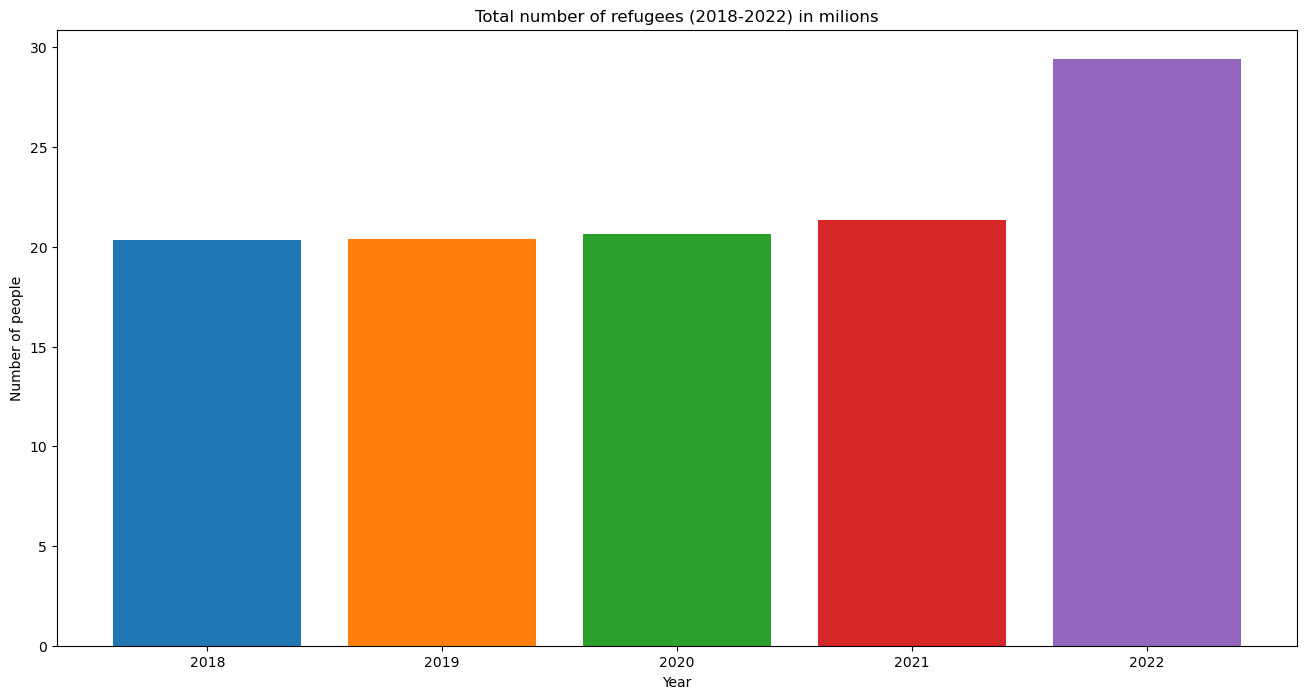

In [36]:
#TODO change le7 to le6
plt.figure(figsize =(16, 8))
for year in range(2018, 2023):
    un_refuges_data_for_current_year = un_refuges_data[un_refuges_data["Year"] == year]
    total_refugees_data_for_all_years = un_refuges_data_for_current_year.groupby(["Country of origin"])["Refugees under UNHCR's mandate"].sum()
    plt.bar(year, (total_refugees_data_for_all_years.values.sum() / 1e6))

    plt.xlabel('Year')
    plt.ylabel('Number of people')
    plt.title(f'Total number of refugees (2018-2022) in milions')
plt.show()

It is interesting to note that during the global COVID-19 pandemic (starts 30 January 2020), we do not observe a change in the number of refugees. There might be a connection, but these data do not directly show it, and therefore we will not dive into this topic. 

That we see is there is a significant increase of refugees in 2022, which might be due to the war in Ukraine. 

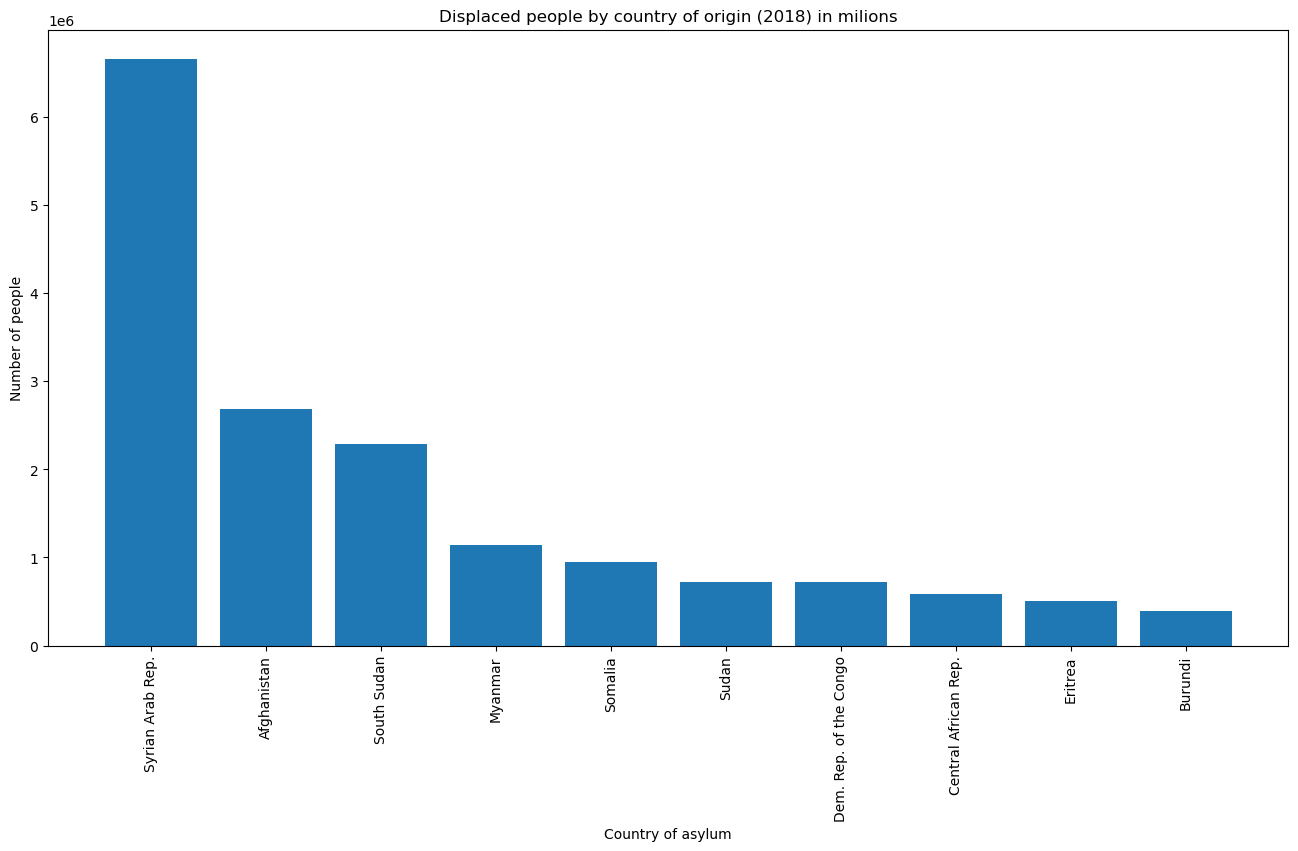

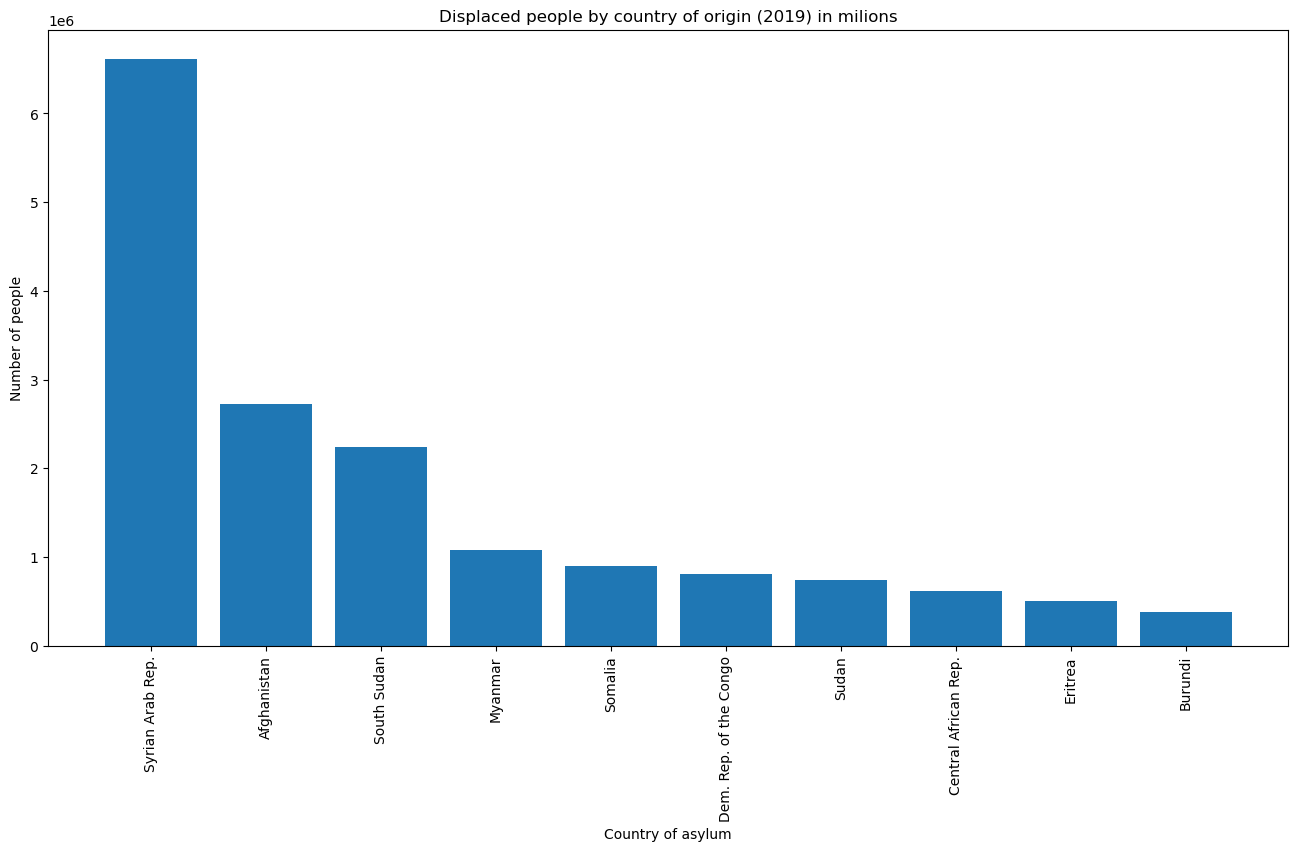

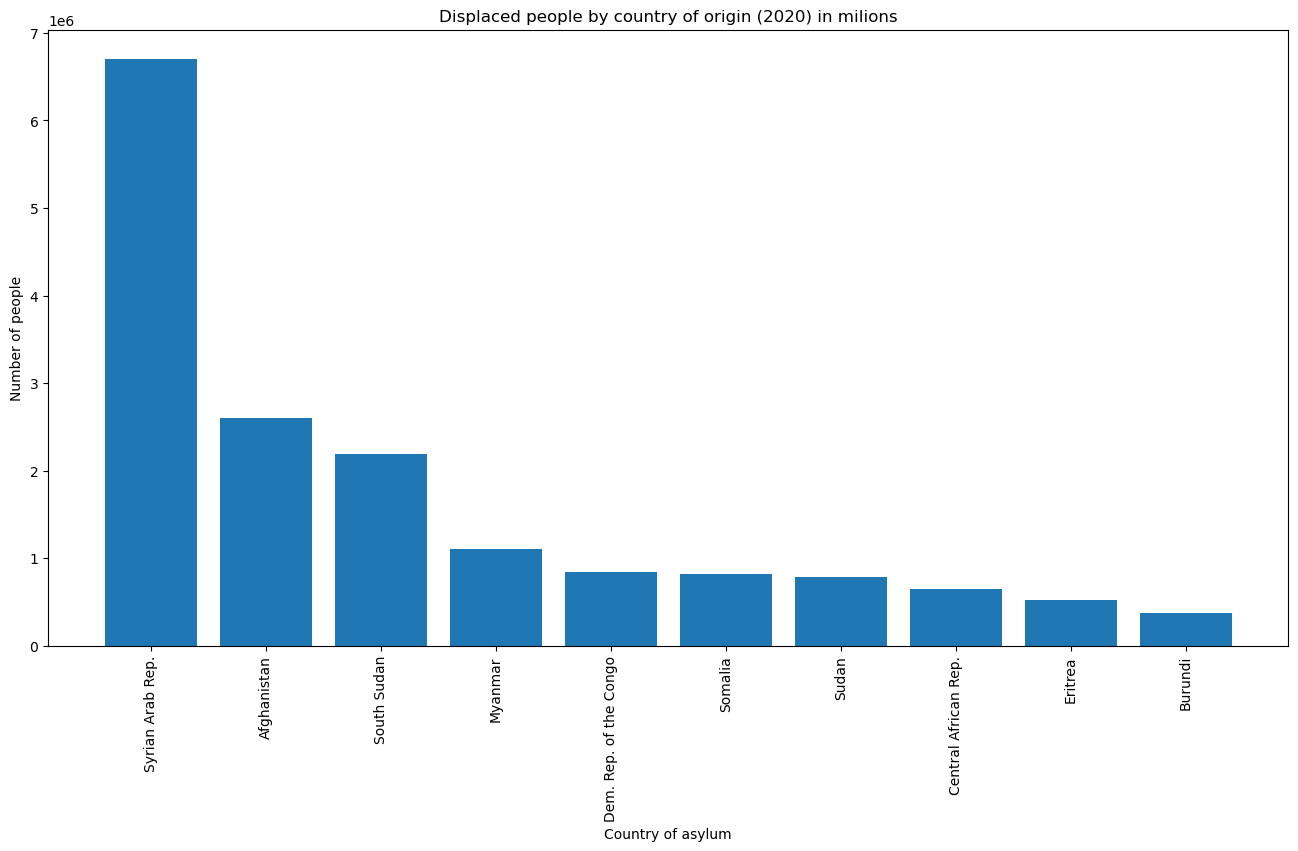

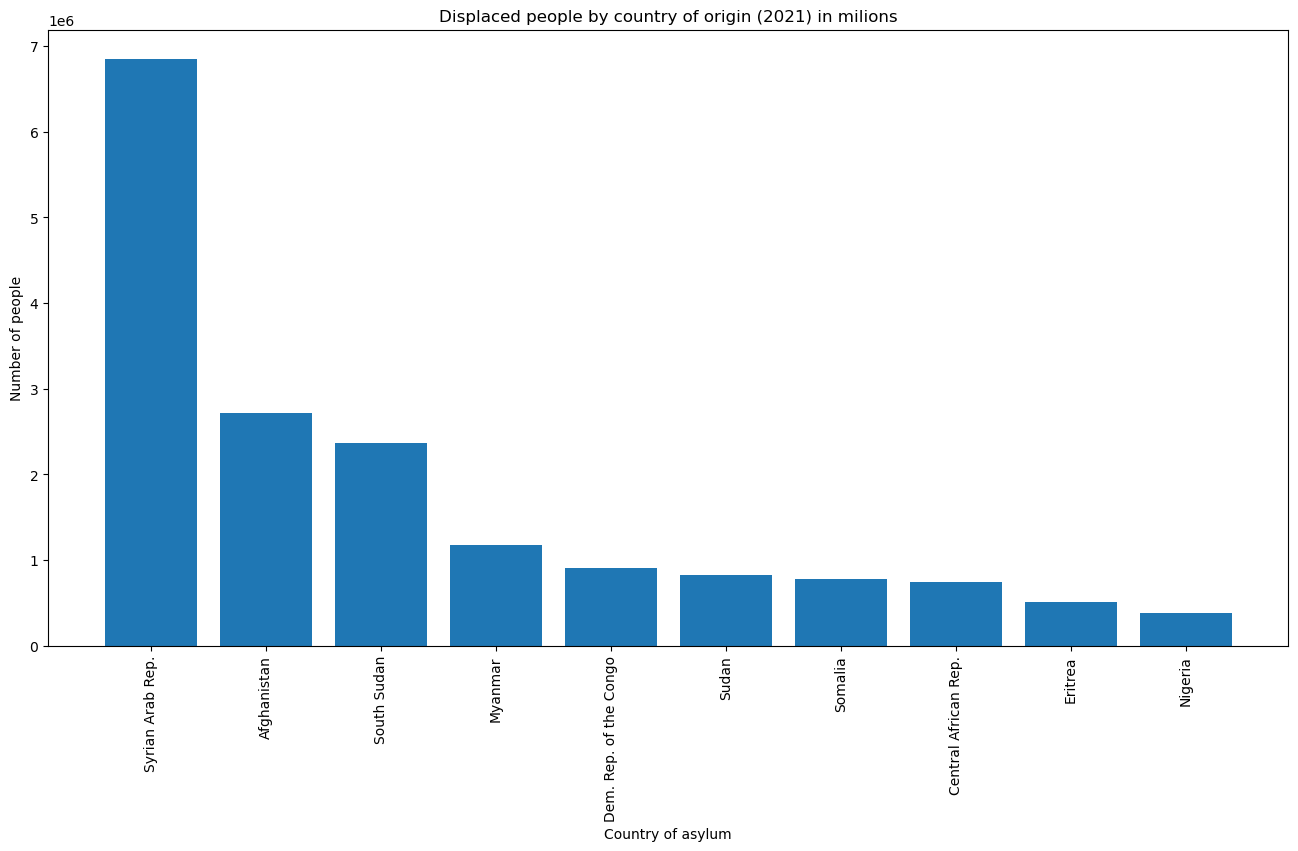

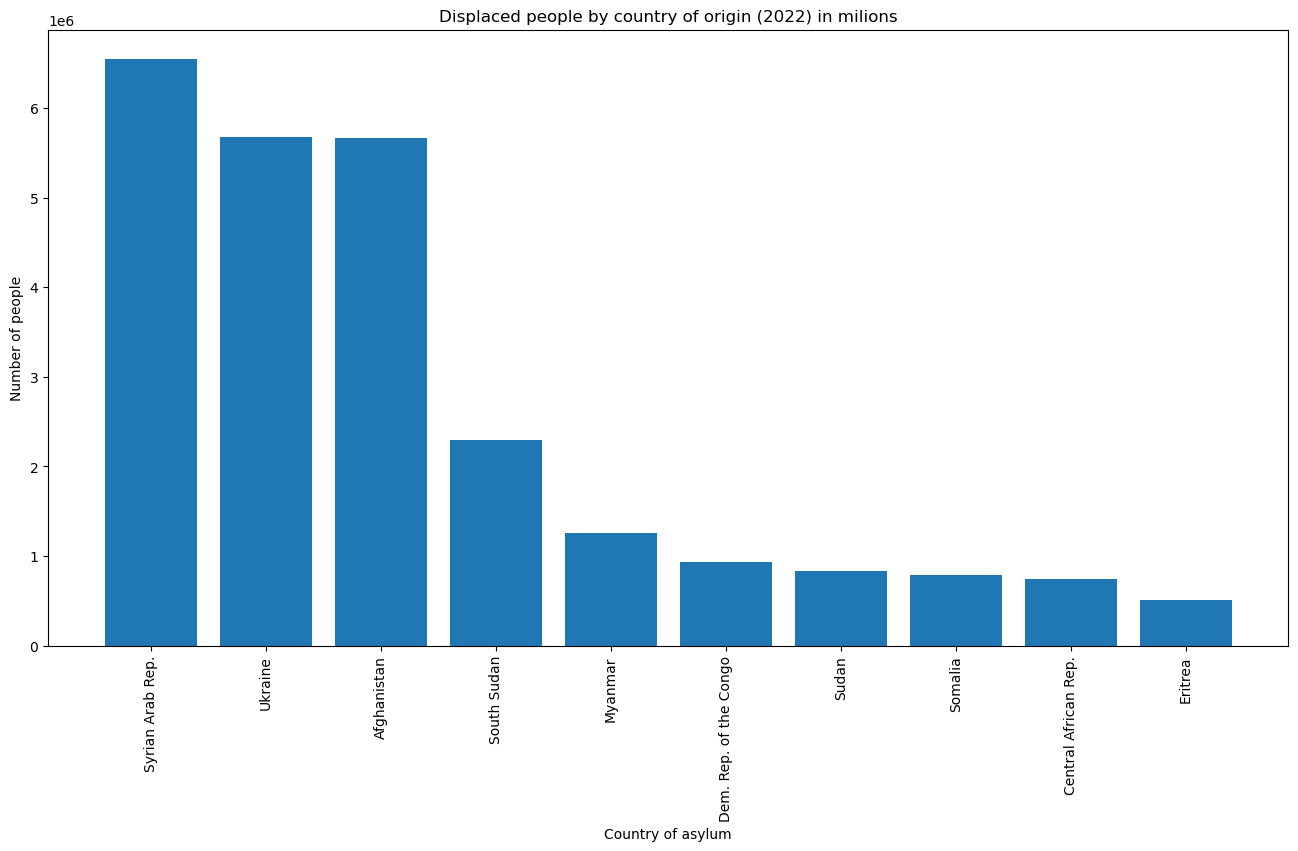

In [37]:
for year in range(2018, 2023):
    un_refuges_data_for_current_year = un_refuges_data[un_refuges_data["Year"] == year]
    countries_of_origin_with_largest_amount_refugees = un_refuges_data_for_current_year.groupby(["Country of origin"])["Refugees under UNHCR's mandate"].sum().nlargest(10)

    plt.figure(figsize =(16, 8))

    plt.bar(countries_of_origin_with_largest_amount_refugees.index, countries_of_origin_with_largest_amount_refugees.values)

    plt.xlabel('Country of asylum')
    plt.ylabel('Number of people')
    plt.title(f'Displaced people by country of origin ({year}) in milions')
    plt.xticks(rotation=90) 
    plt.show()

Again, it is interesting to see Ukraine ranking second in terms of refugees, especially when in previous years it did not even make it to the ten countries with the most refugees.

After observing this, it's now time to look at the countries of asylum and their distribution over years (2018-2022).

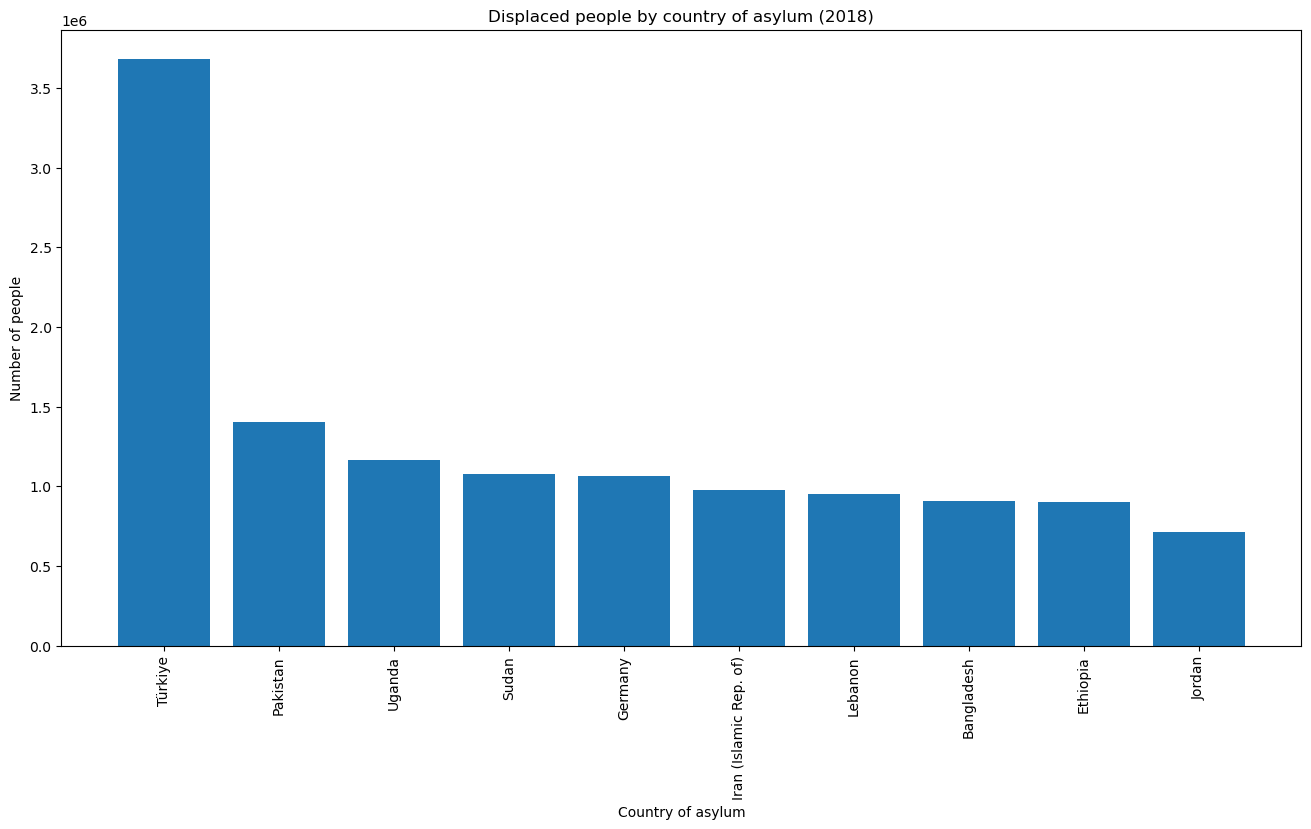

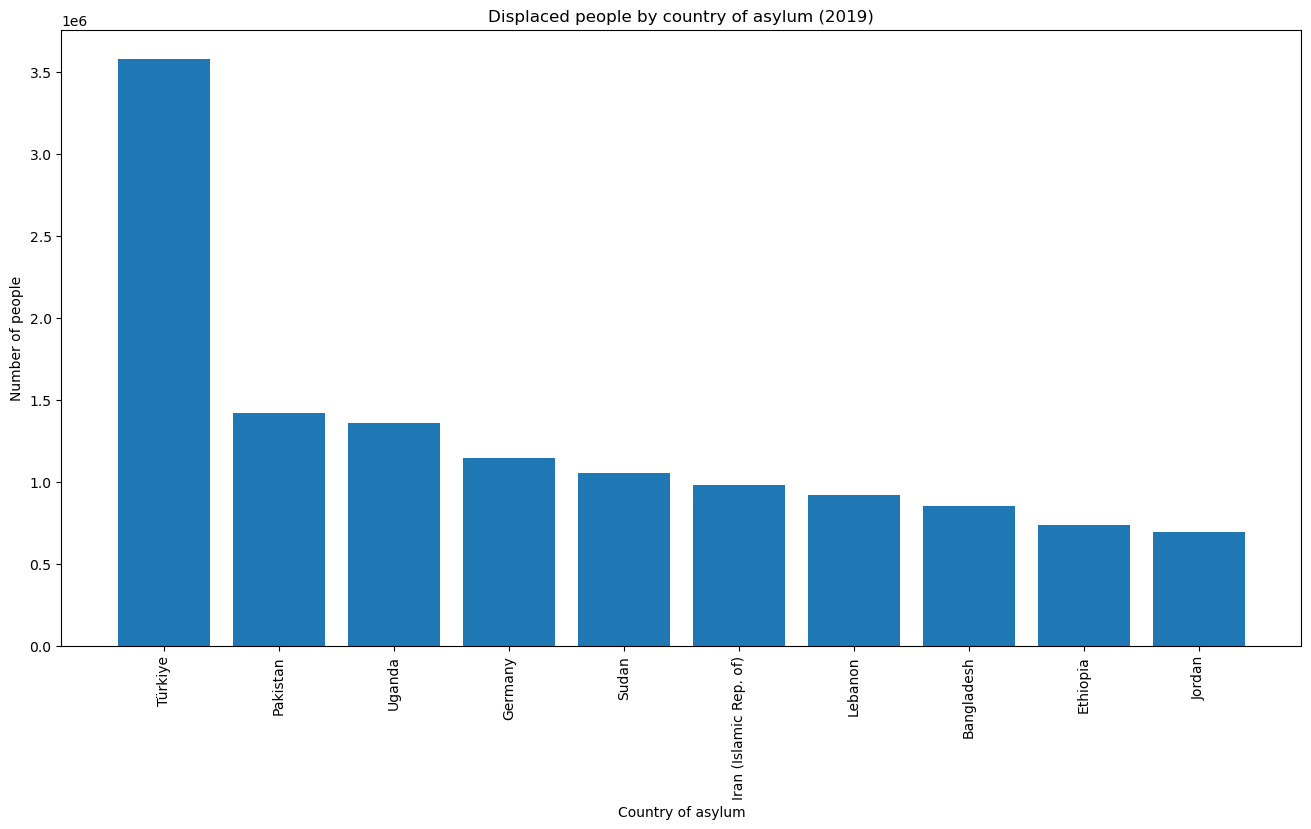

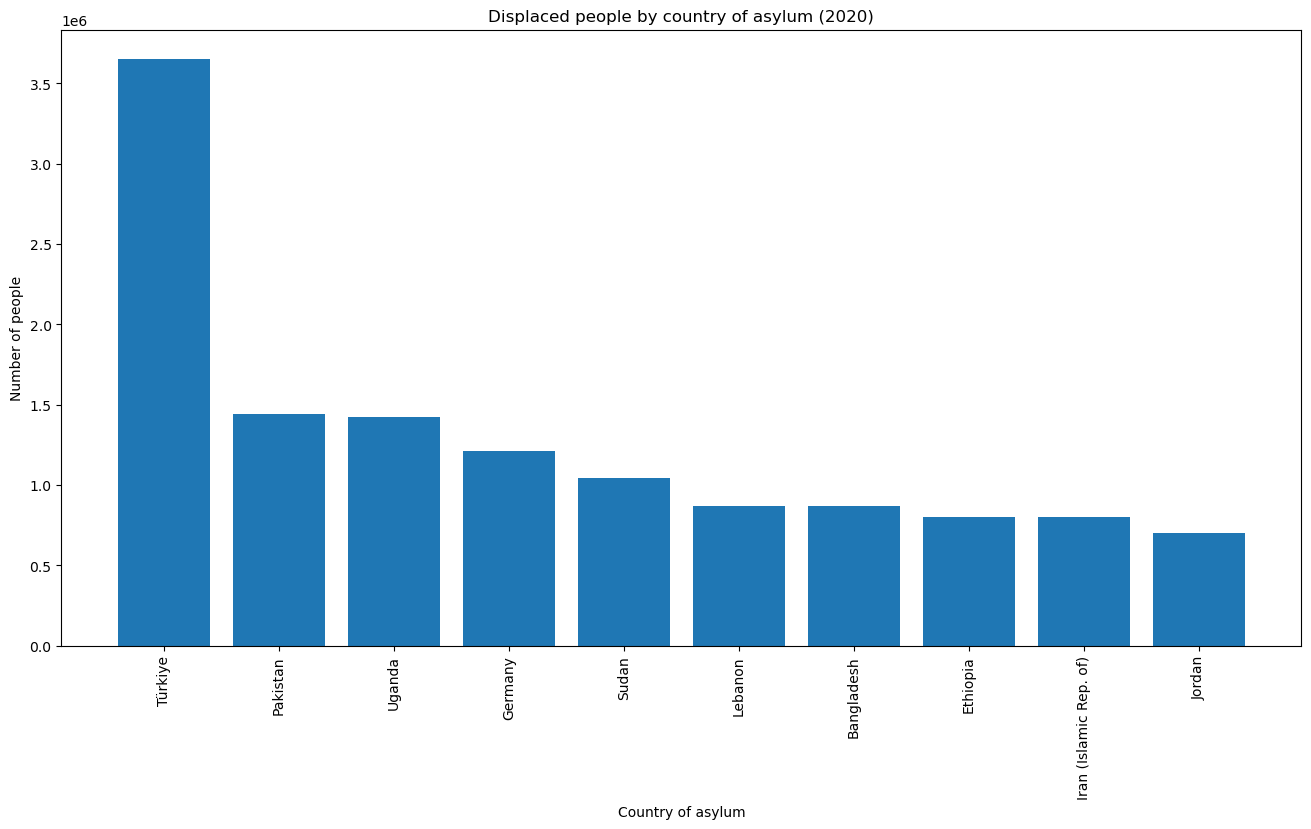

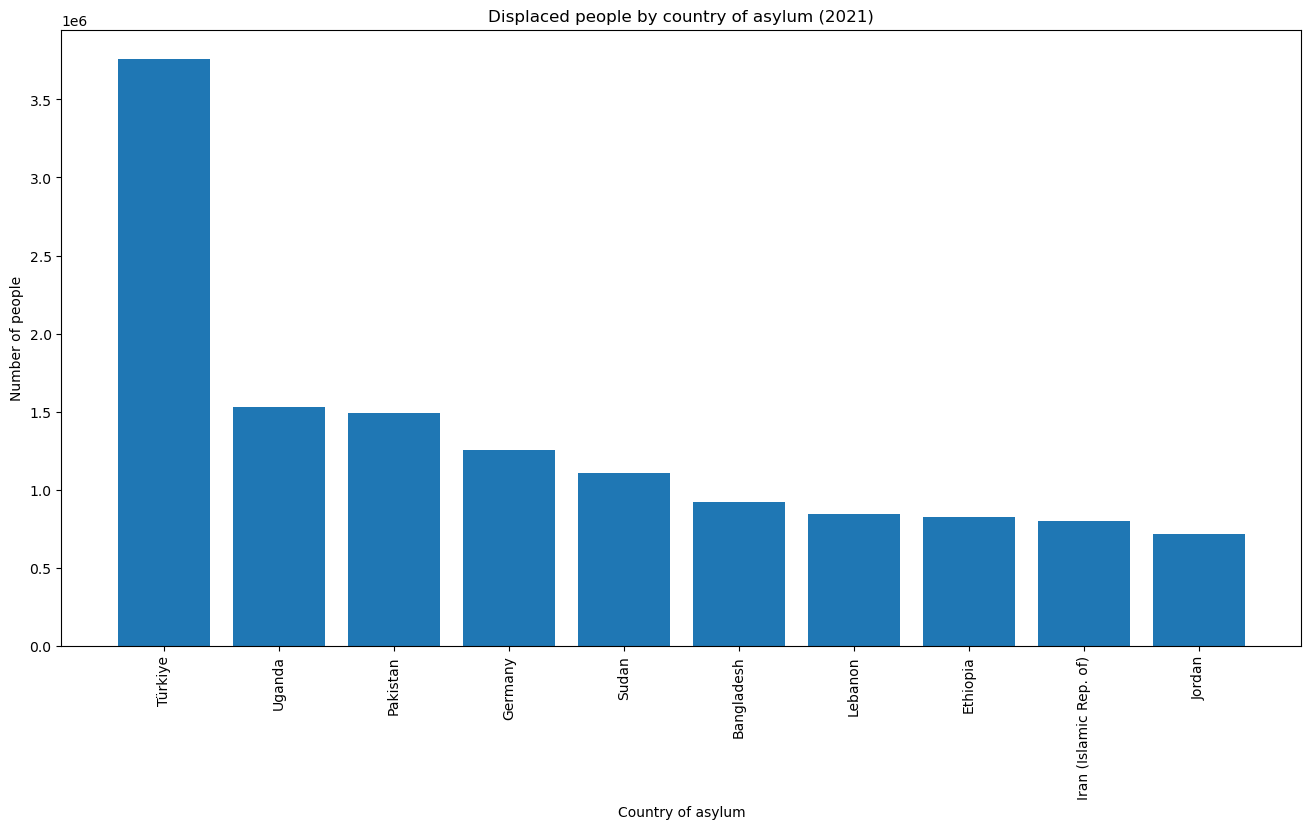

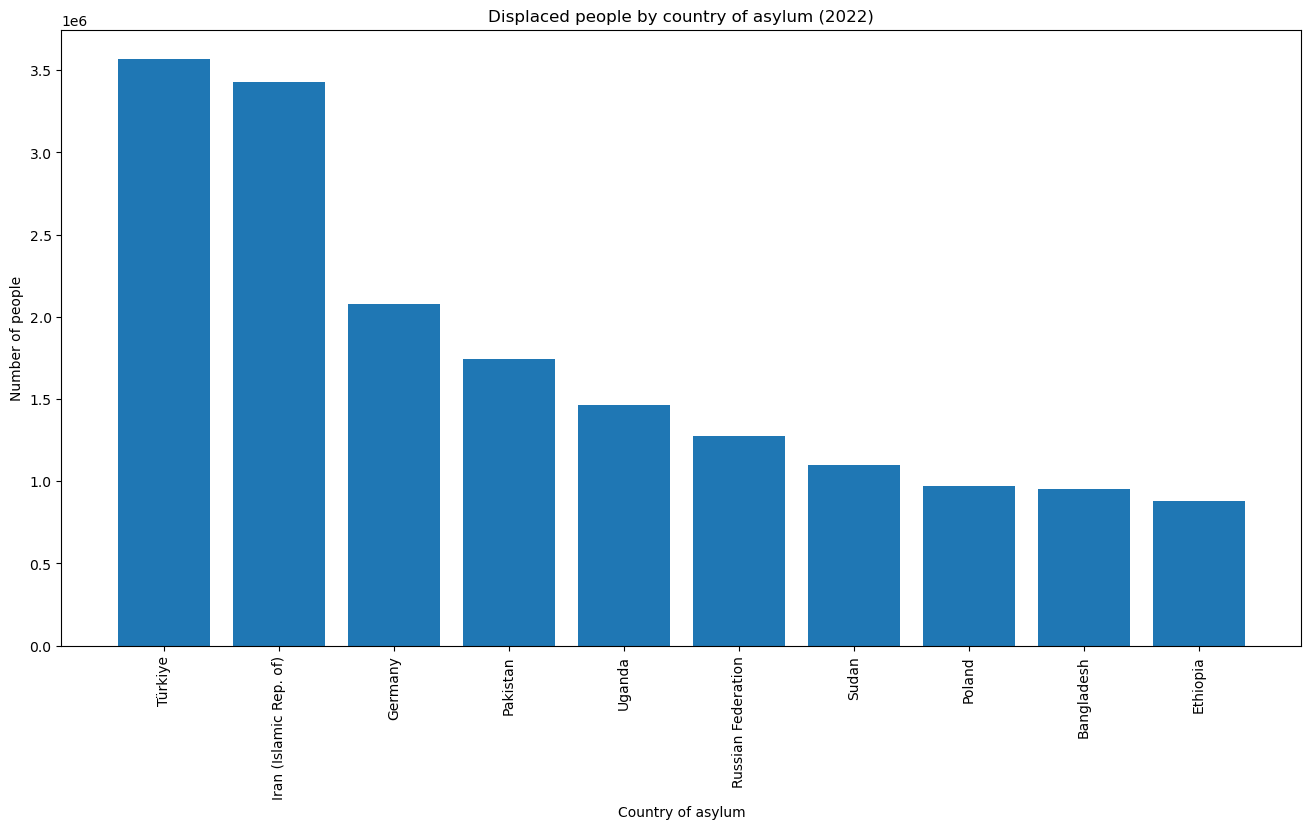

In [38]:
for year in range(2018, 2023):
    un_refuges_data_for_current_year = un_refuges_data[un_refuges_data["Year"] == year]
    countries_of_asylum_with_largest_amount_refugees = un_refuges_data_for_current_year.groupby(["Country of asylum"])["Refugees under UNHCR's mandate"].sum().nlargest(10)

    plt.figure(figsize =(16, 8))

    plt.bar(countries_of_asylum_with_largest_amount_refugees.index, countries_of_asylum_with_largest_amount_refugees.values)

    plt.xlabel('Country of asylum')
    plt.ylabel('Number of people')
    plt.title(f'Displaced people by country of asylum ({year})')
    plt.xticks(rotation=90) 
    plt.show()


In [39]:
refugees_in_russia = un_refuges_data[(un_refuges_data["Year"] == 2022) & (un_refuges_data["Country of asylum"] == "Russian Federation")]["Refugees under UNHCR's mandate"].sum()
refugees_in_russia

1277672

In [40]:
refugees_in_russia_from_ukraine = un_refuges_data[(un_refuges_data["Year"] == 2022) & (un_refuges_data["Country of asylum"] == "Russian Federation") &(un_refuges_data["Country of origin"] == "Ukraine")]["Refugees under UNHCR's mandate"].sum()
refugees_in_russia_from_ukraine

1275315

From bar charts, we observe that Turkey ranks first in terms of accepted refugees. Again, there is a significant shift and increase in the number of refugees accepted by Iran and Germany for year 2022. 

It's also interesting to see the appearance of the Russian Federation as a asylum of 1277672 refugees (almost all are from Ukraine).

Now, we are examining the correlation of where refugees from a five countries with most refugees with country of origin, country of asylum and their numbers for 2022. 

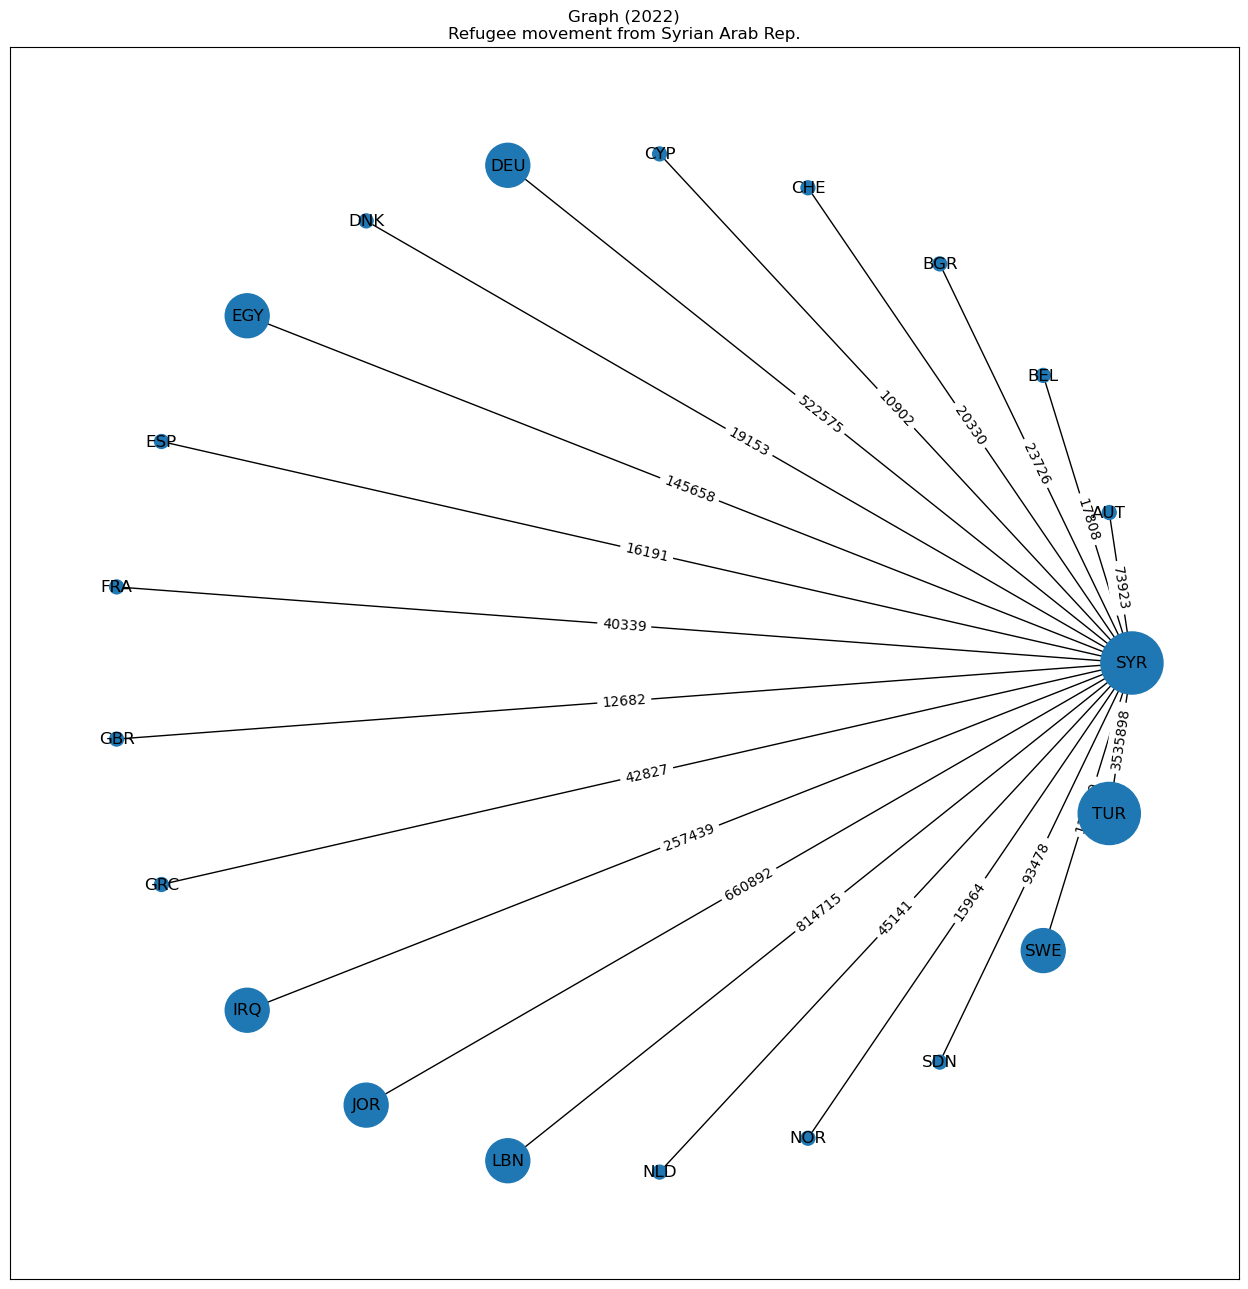

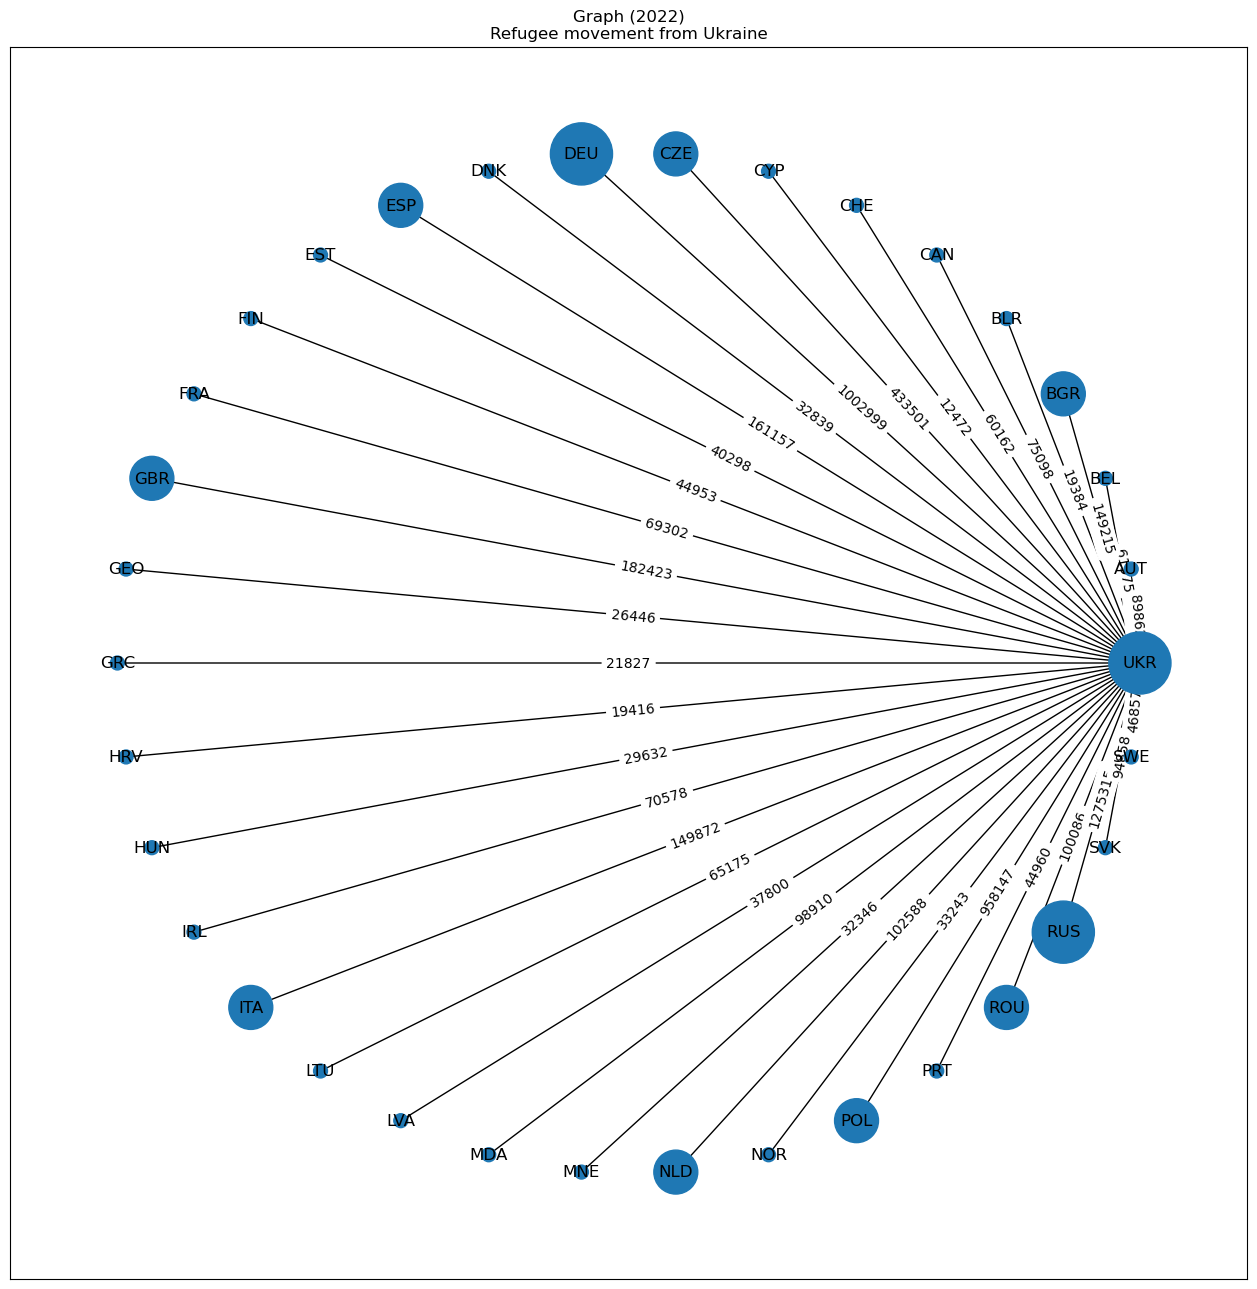

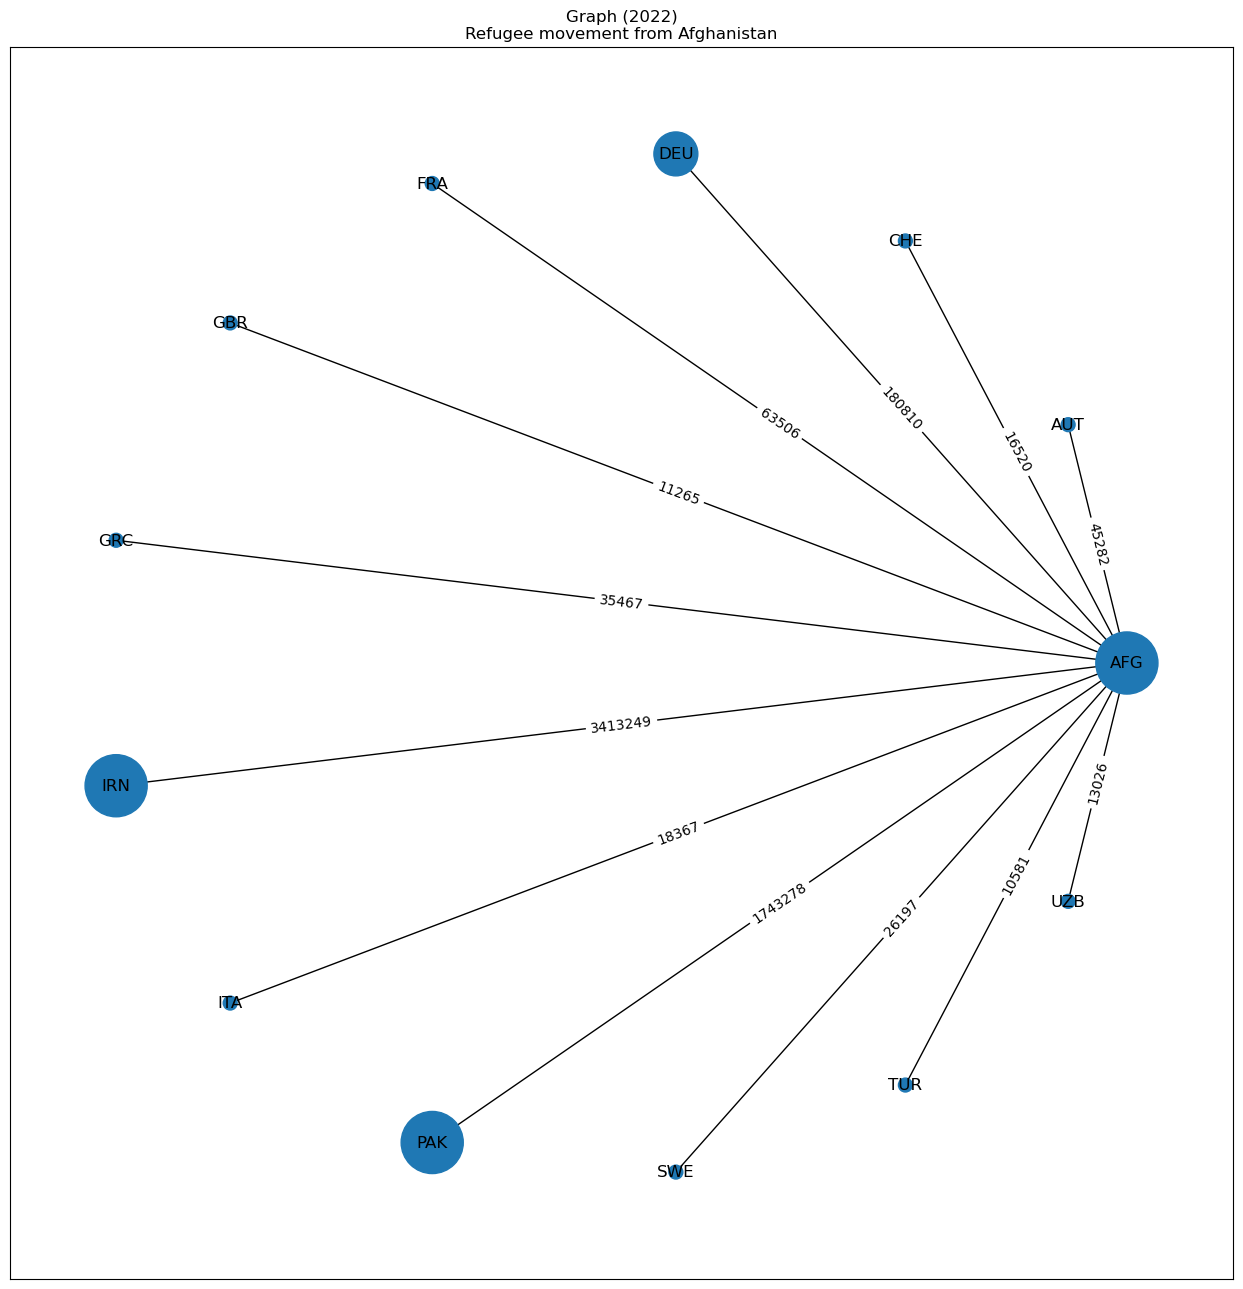

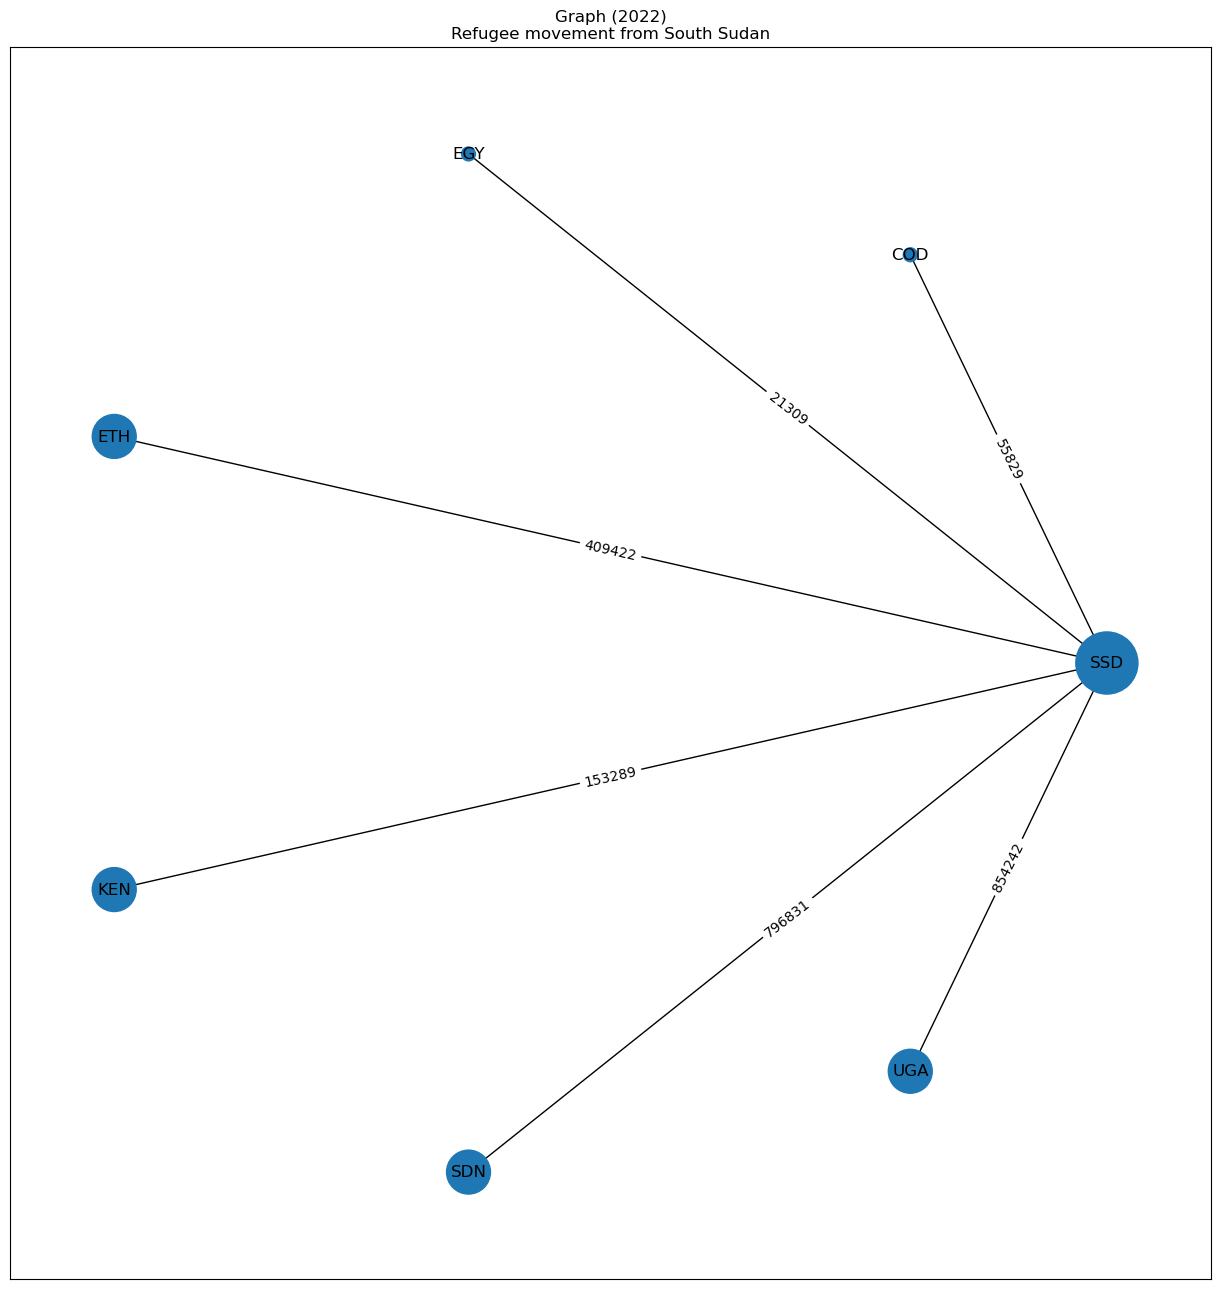

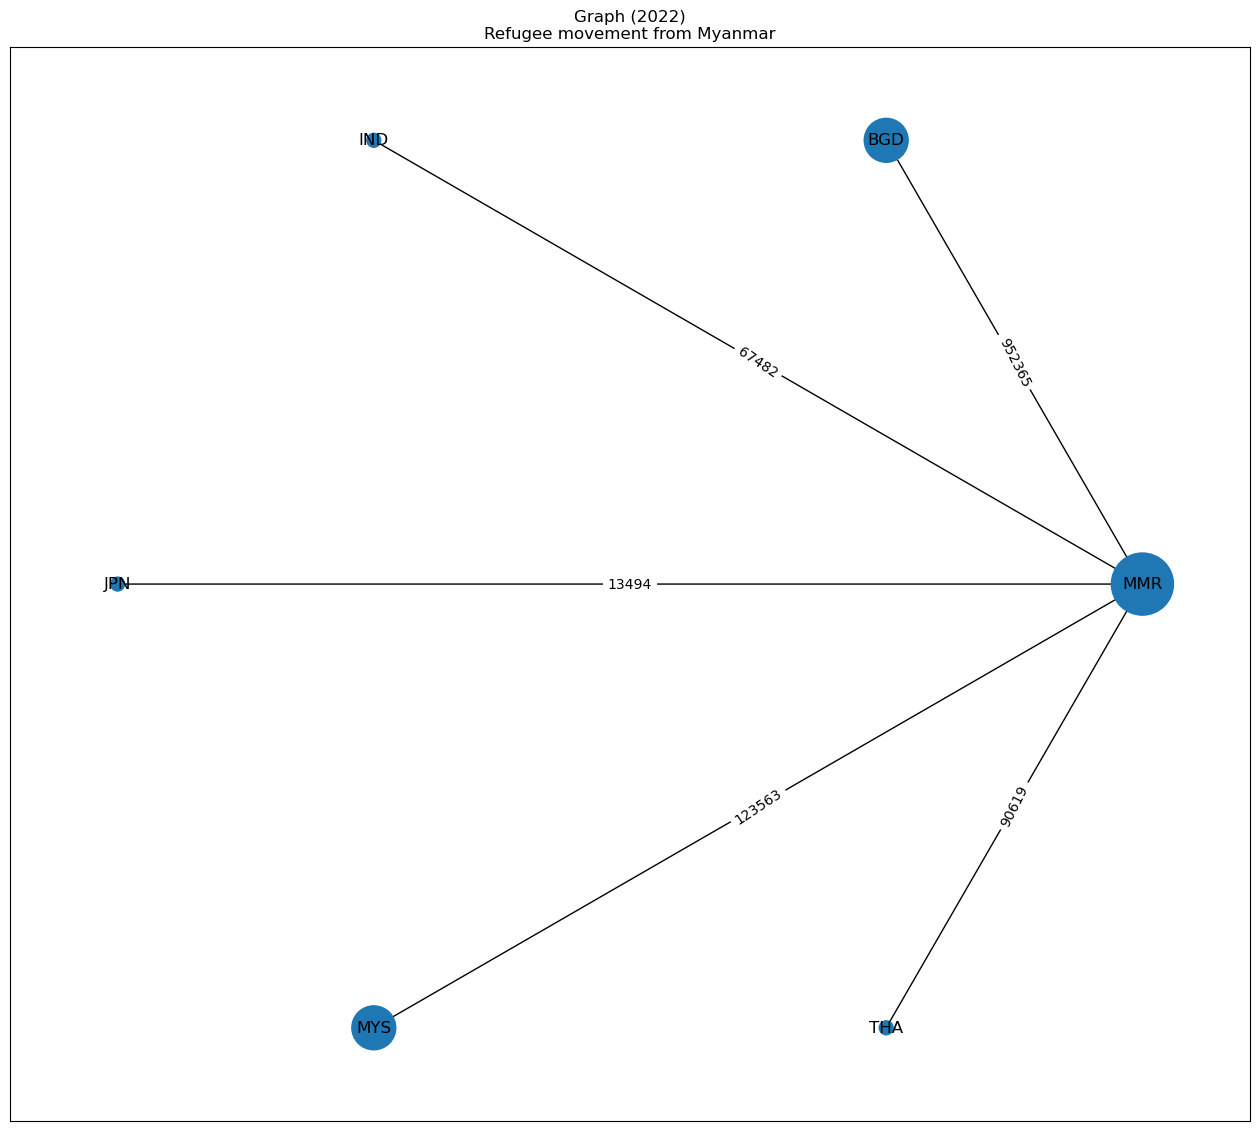

In [41]:
COUNTRY_OF_ORIGIN_ISO = ["SYR","UKR", "AFG", "SSD", "MMR"]

for country in COUNTRY_OF_ORIGIN_ISO:
    filtered_data_2018_2022_refugees = un_refuges_data[(un_refuges_data["Country of origin (ISO)"] == country)]
    create_graph_for_country_refugee(filtered_data_2018_2022_refugees)

With help of Geopandas, we will display map for 2022.

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\3509060962.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


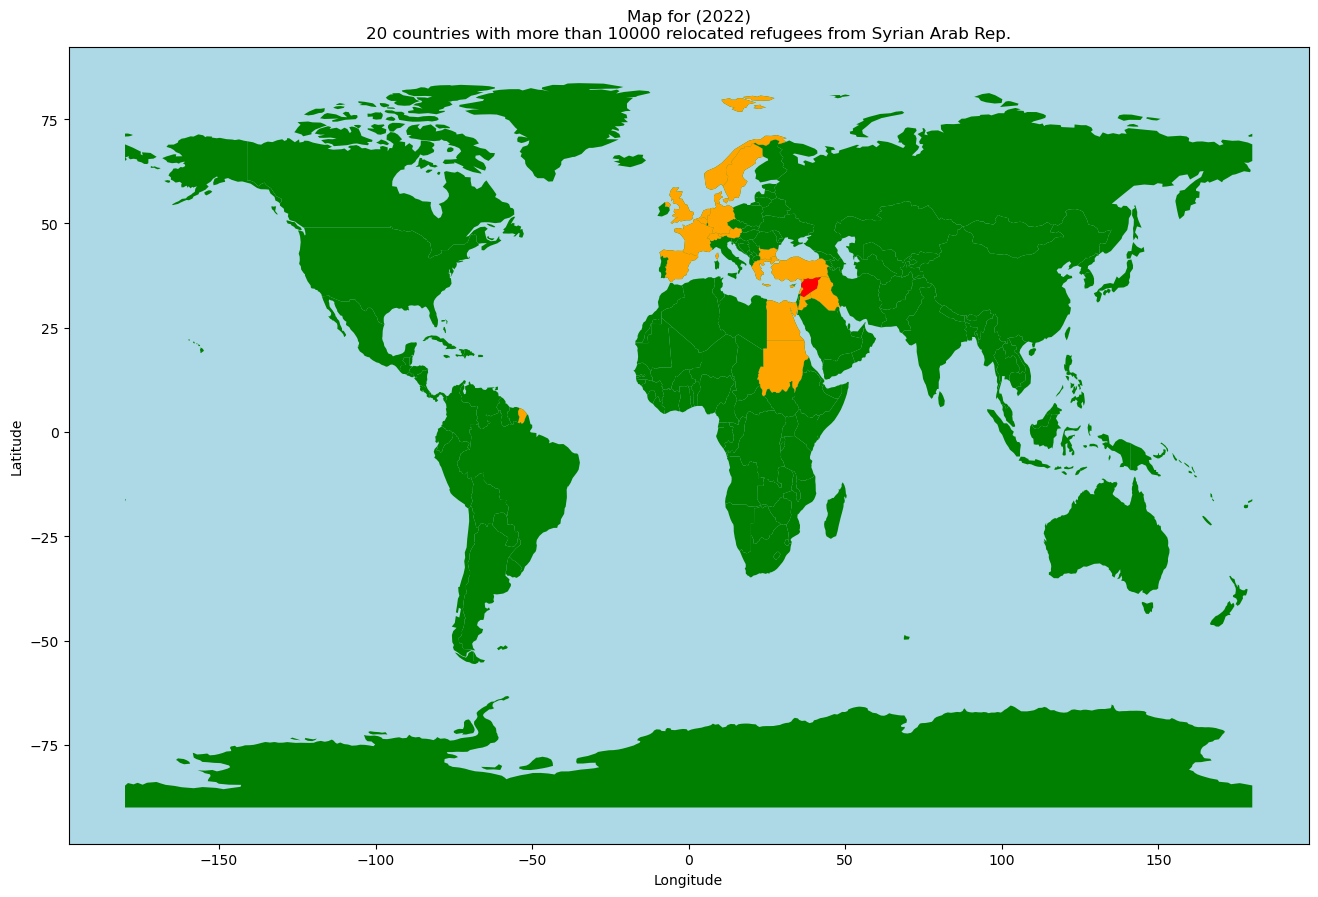

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\3509060962.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


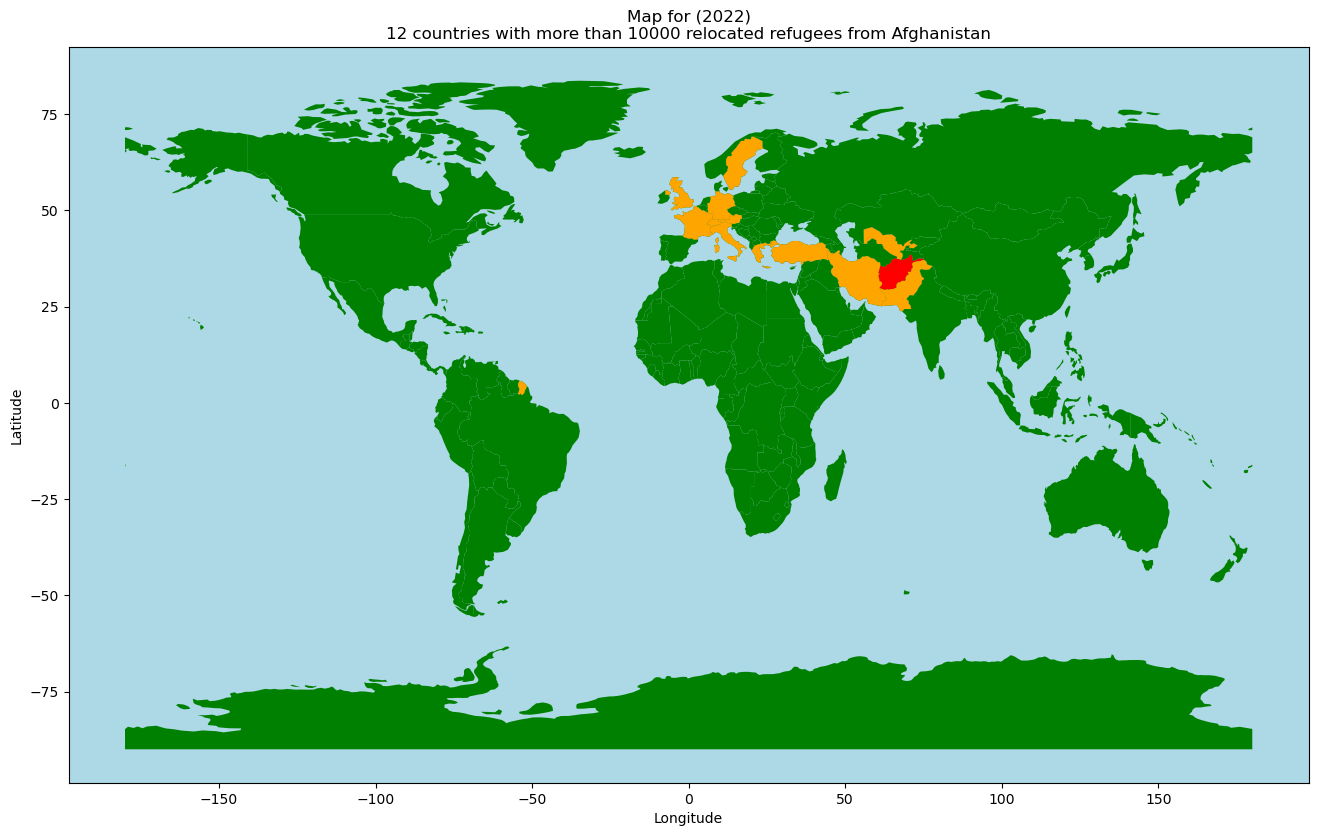

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\3509060962.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


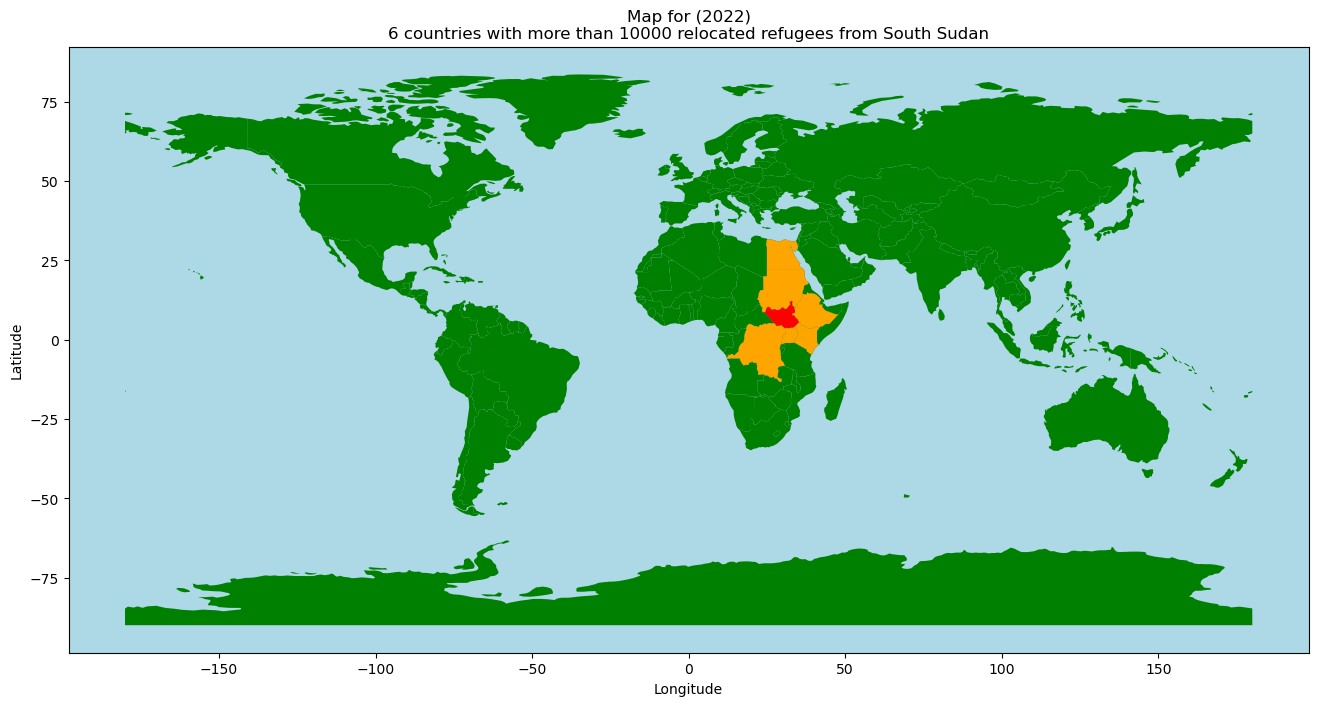

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\3509060962.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


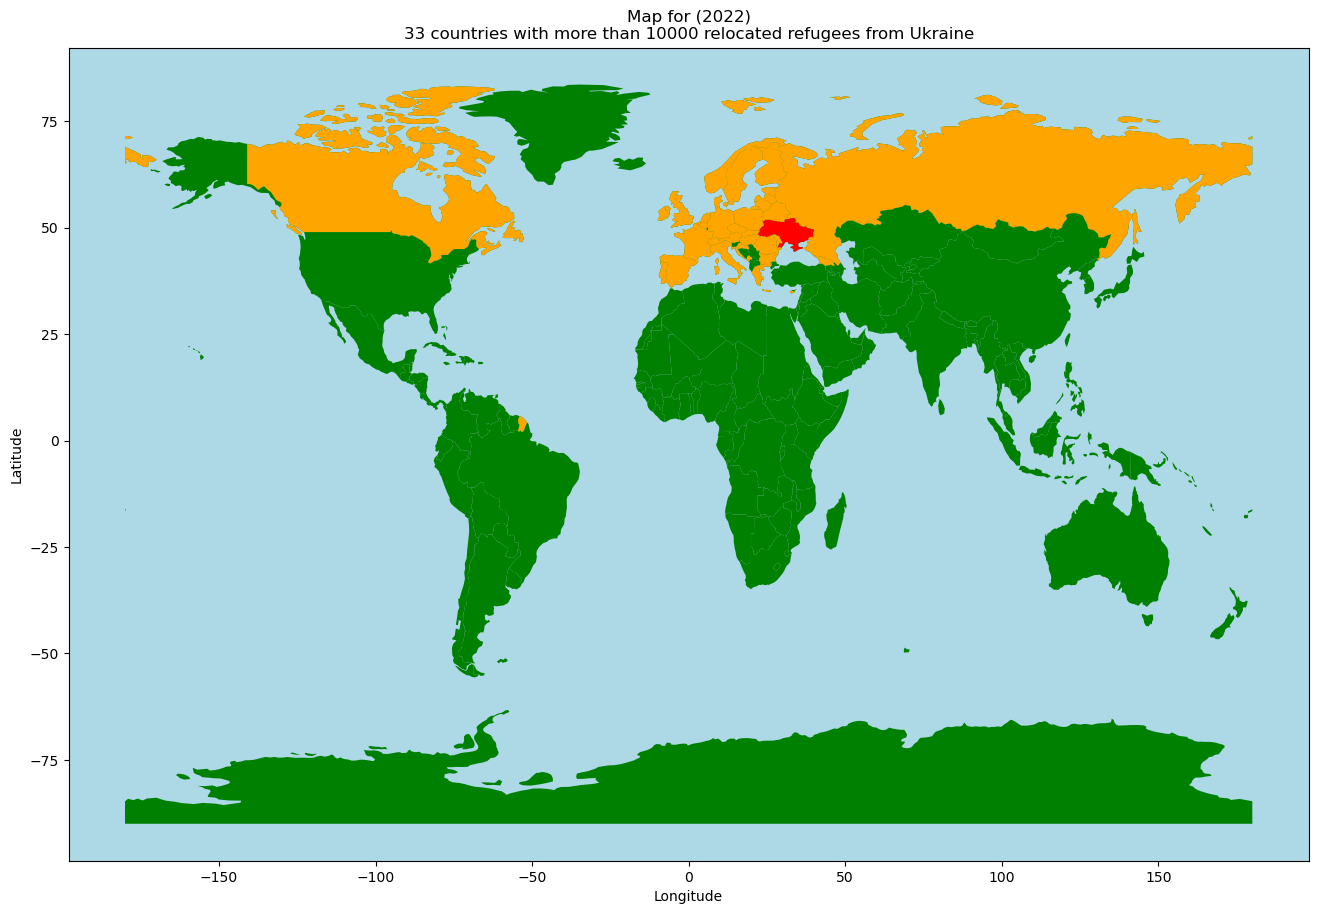

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\3509060962.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


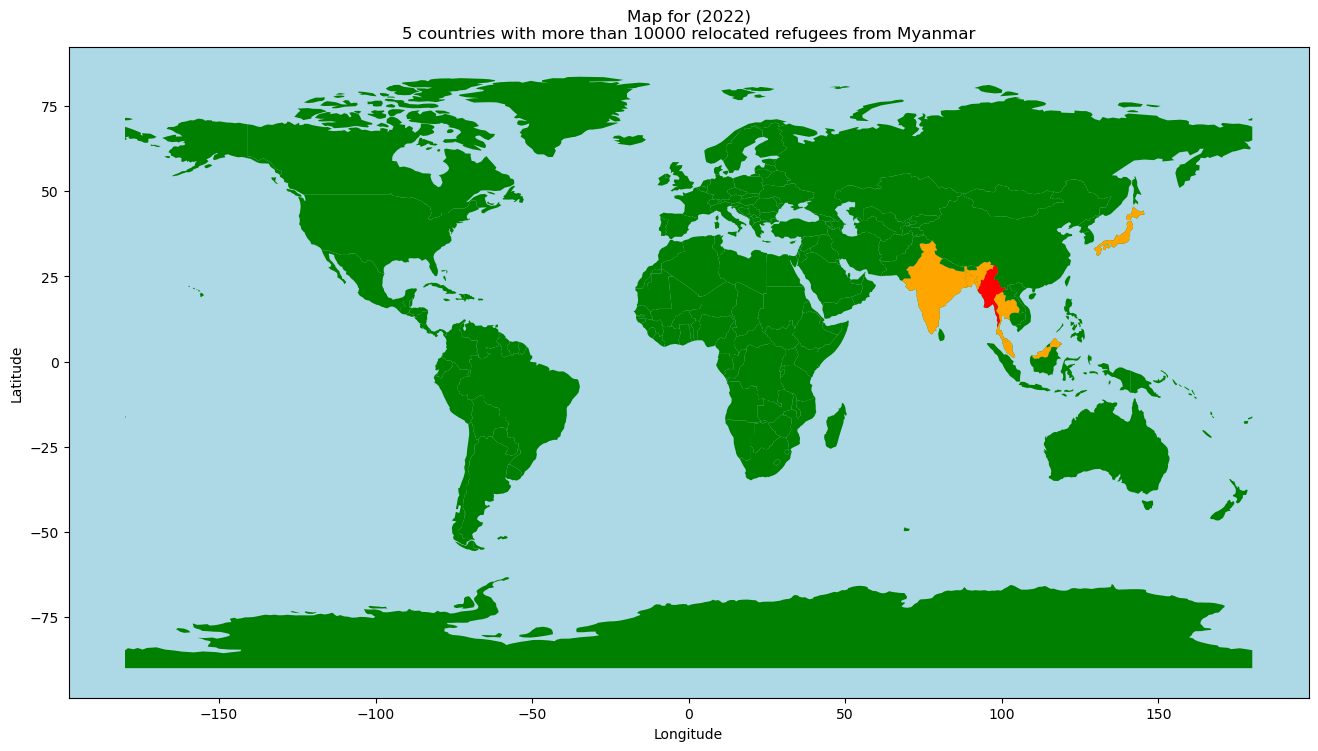

In [42]:
COUNTRY_OF_ORIGIN_ISO = ["SYR", "AFG", "SSD", "UKR", "MMR"]

for country in COUNTRY_OF_ORIGIN_ISO:
    filtered_data_2018_2022_refugees = un_refuges_data[(un_refuges_data["Country of origin (ISO)"] == country)]
    create_map_for_country_refugee(filtered_data_2018_2022_refugees)

We might see that there is a tendency for refugees to be settled in neighboring countries and European Union. 

Now, let's look from perspective of the five countries of asylum with the highest number of refugees.

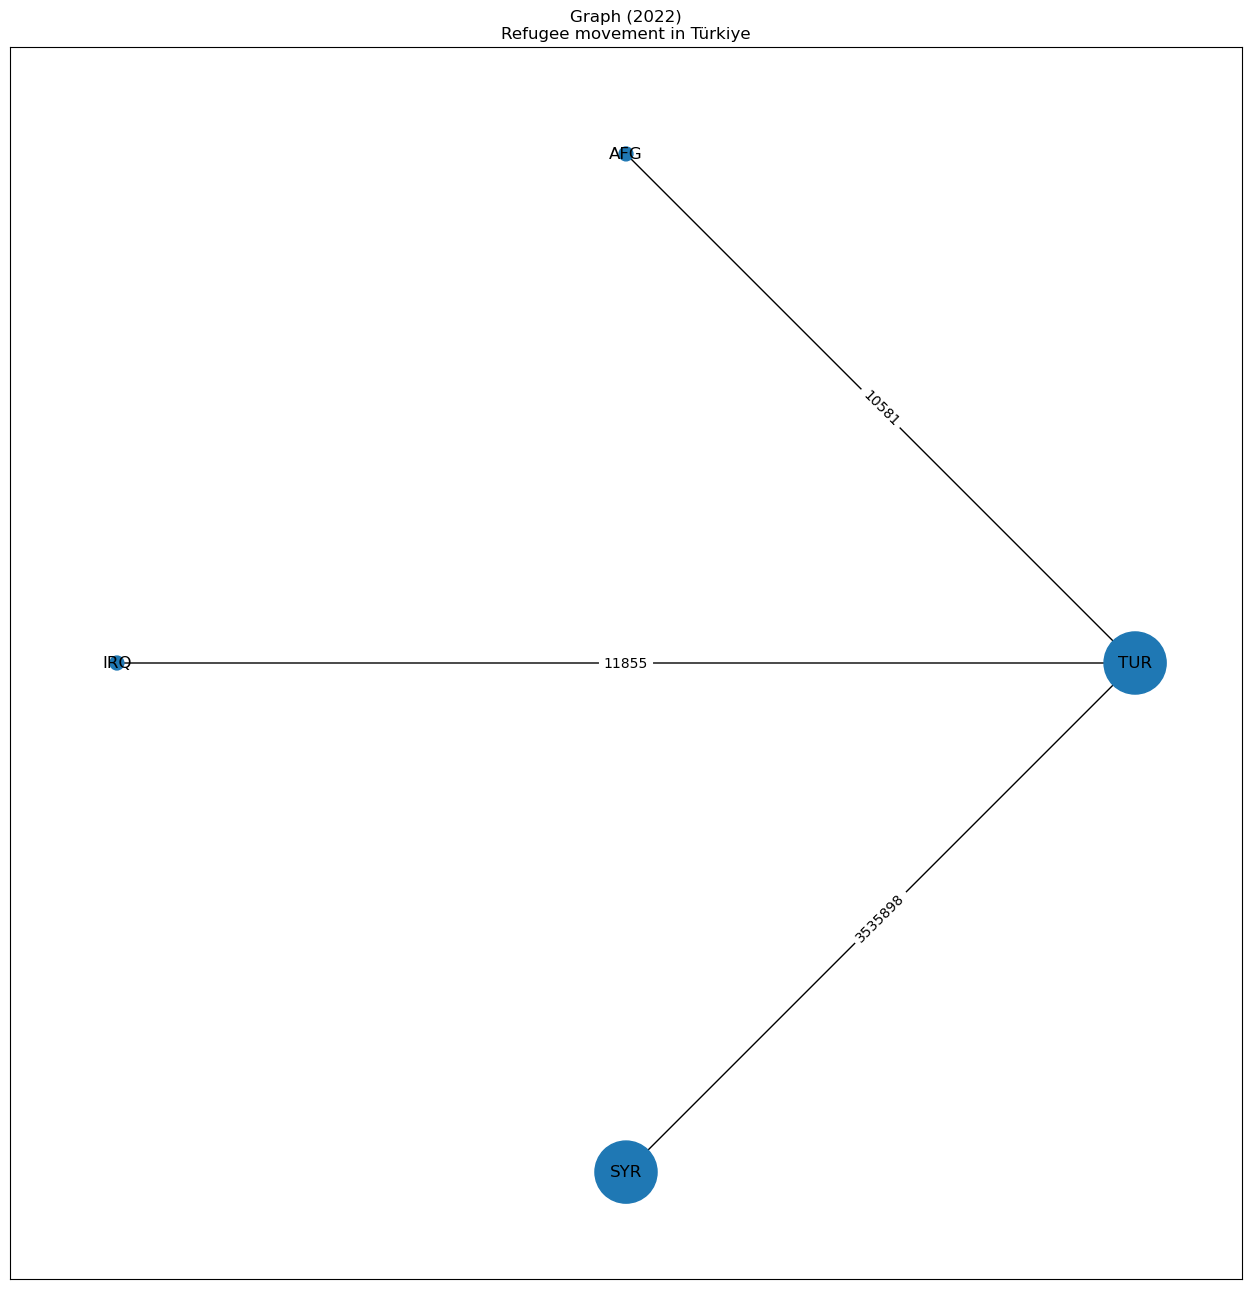

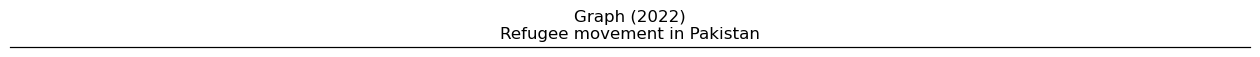

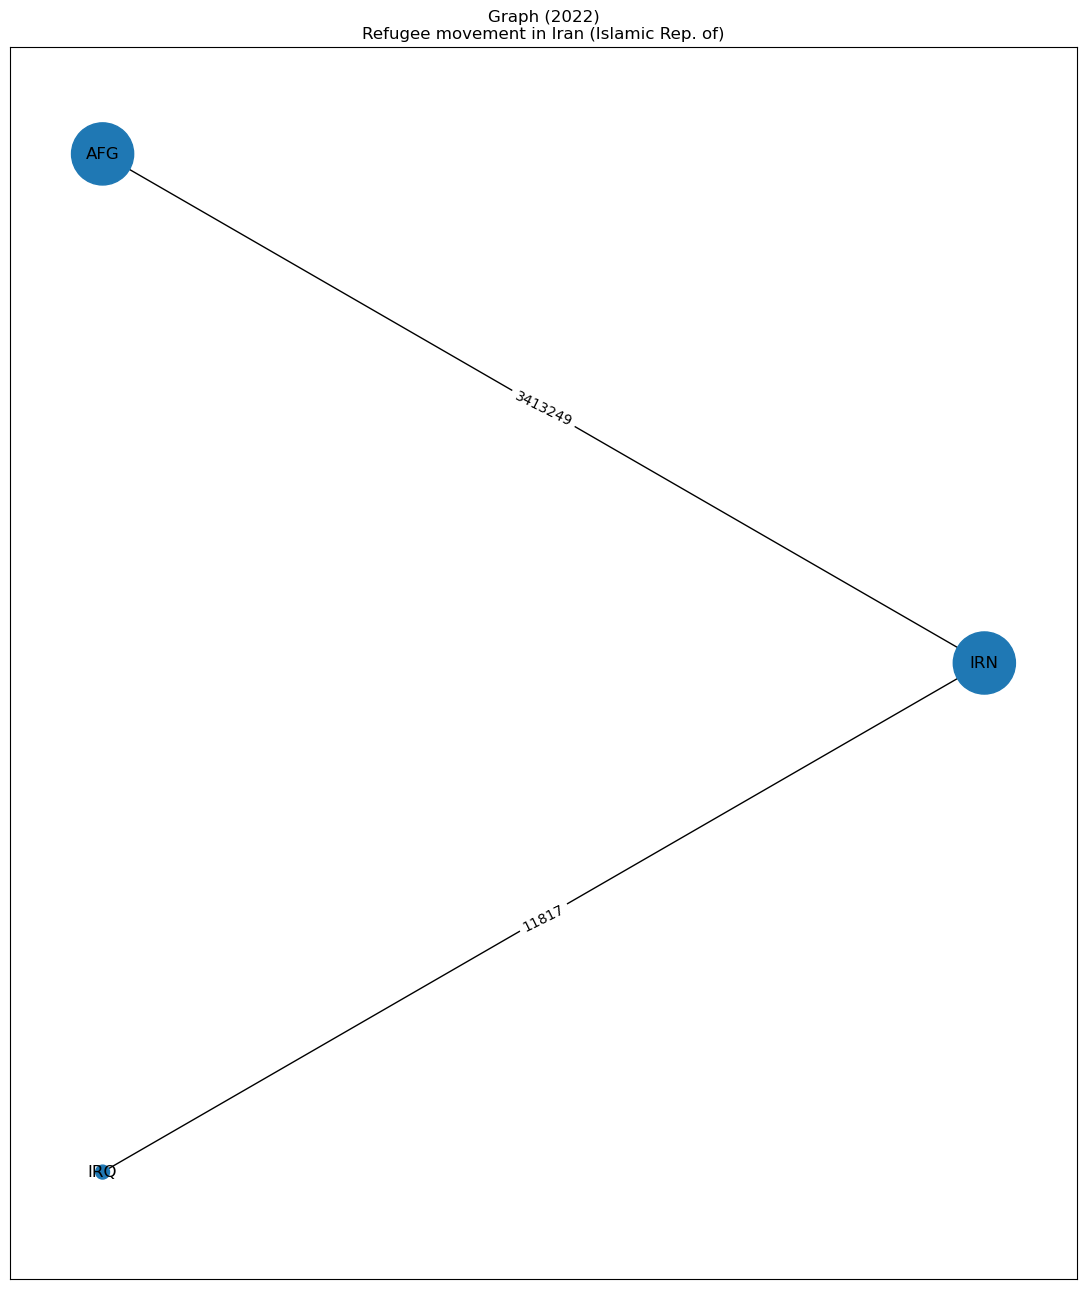

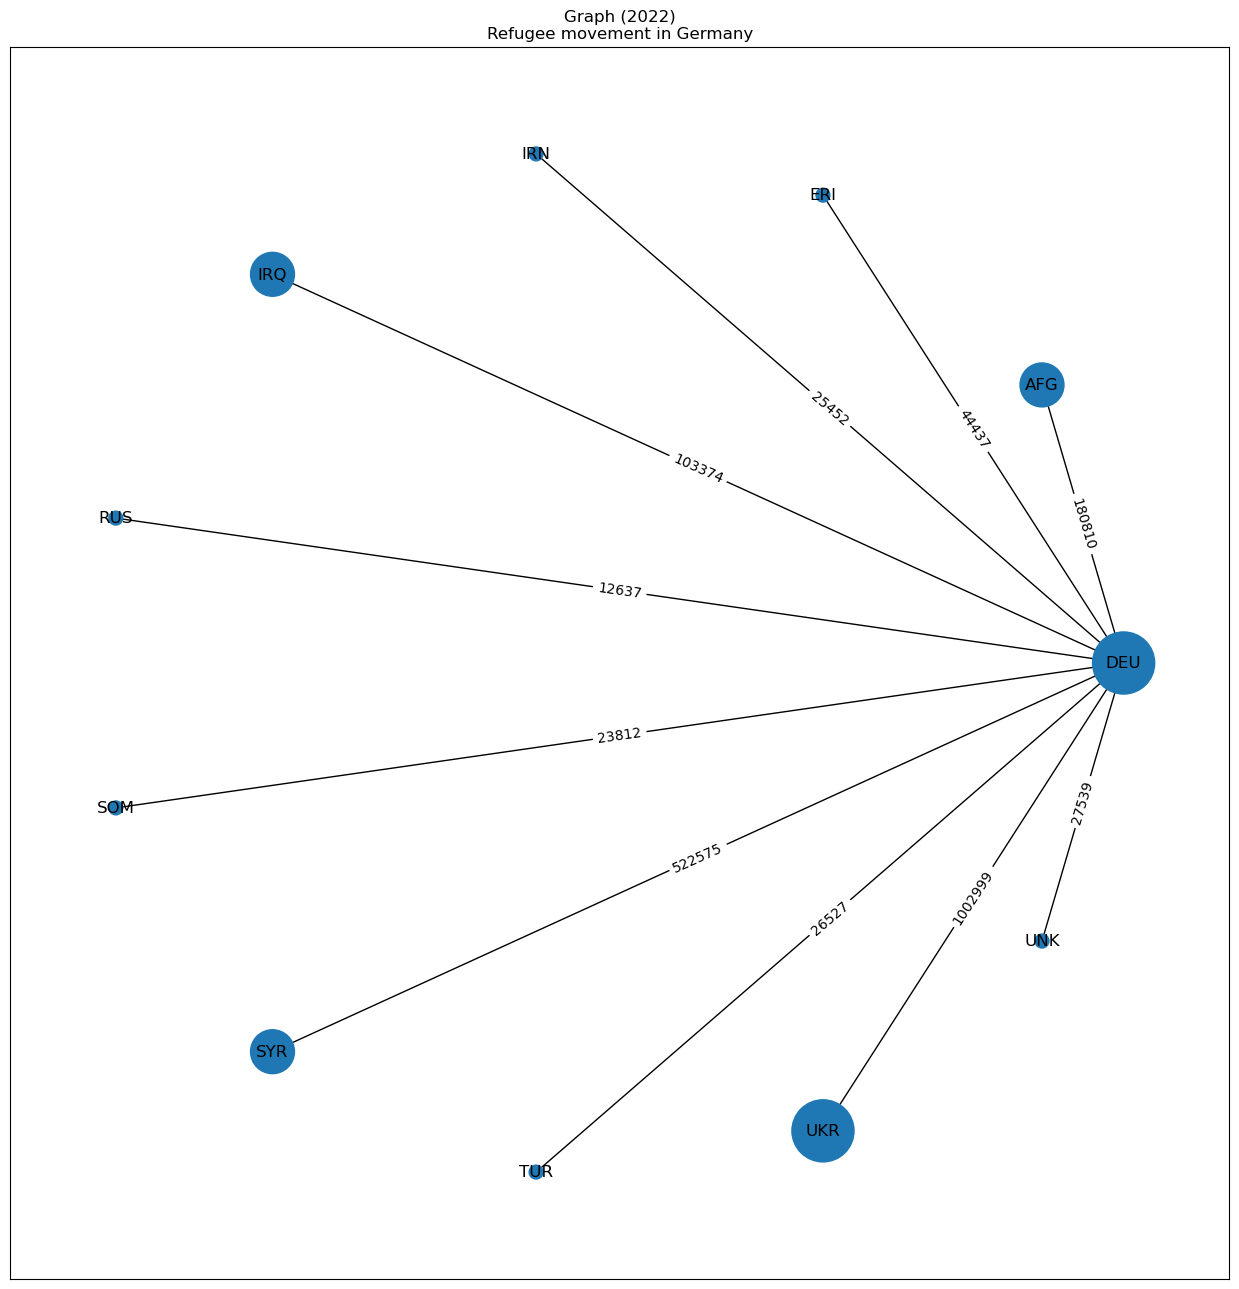

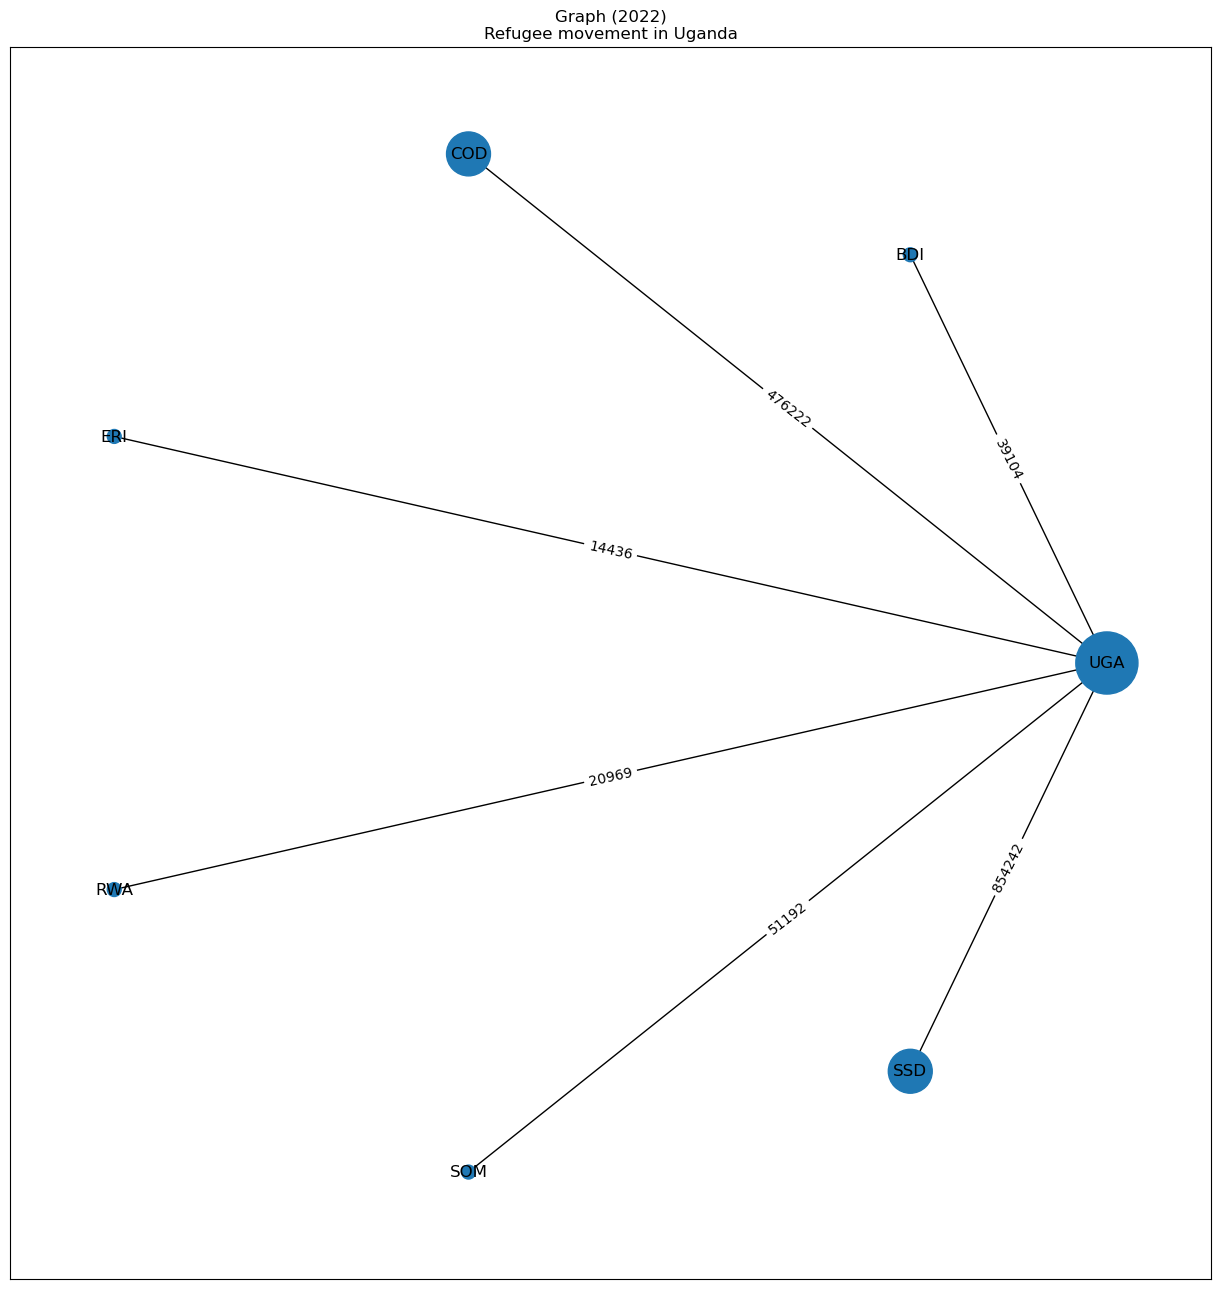

In [43]:
COUNTRY_OF_ASLYM_ISO = ["TUR", "PAK", "IRN", "DEU", "UGA"]

for country in COUNTRY_OF_ASLYM_ISO:
    filtered_data_2018_2022_aslym = un_refuges_data[(un_refuges_data["Country of asylum (ISO)"] == country)]
    create_graph_for_country_aslym(filtered_data_2018_2022_aslym)

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1283298436.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


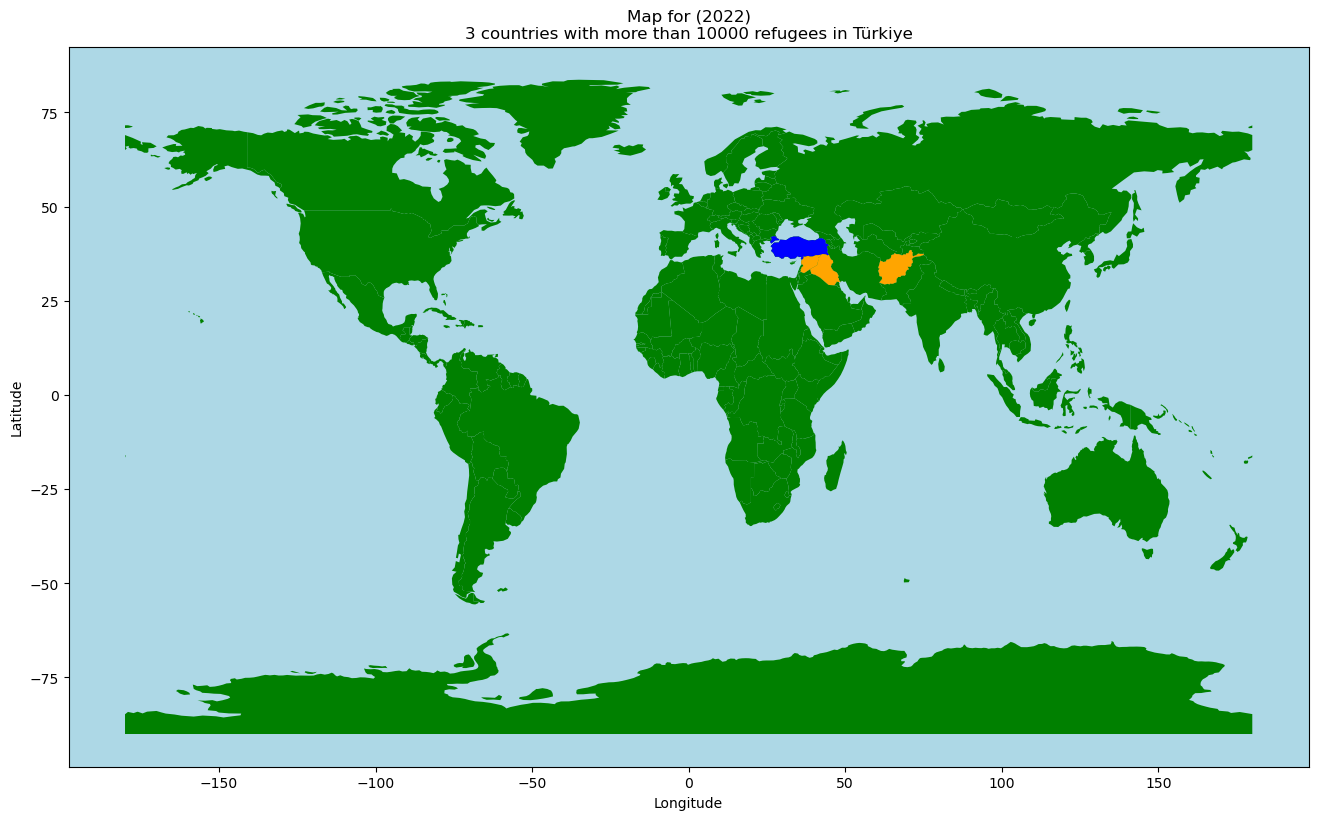

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1283298436.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


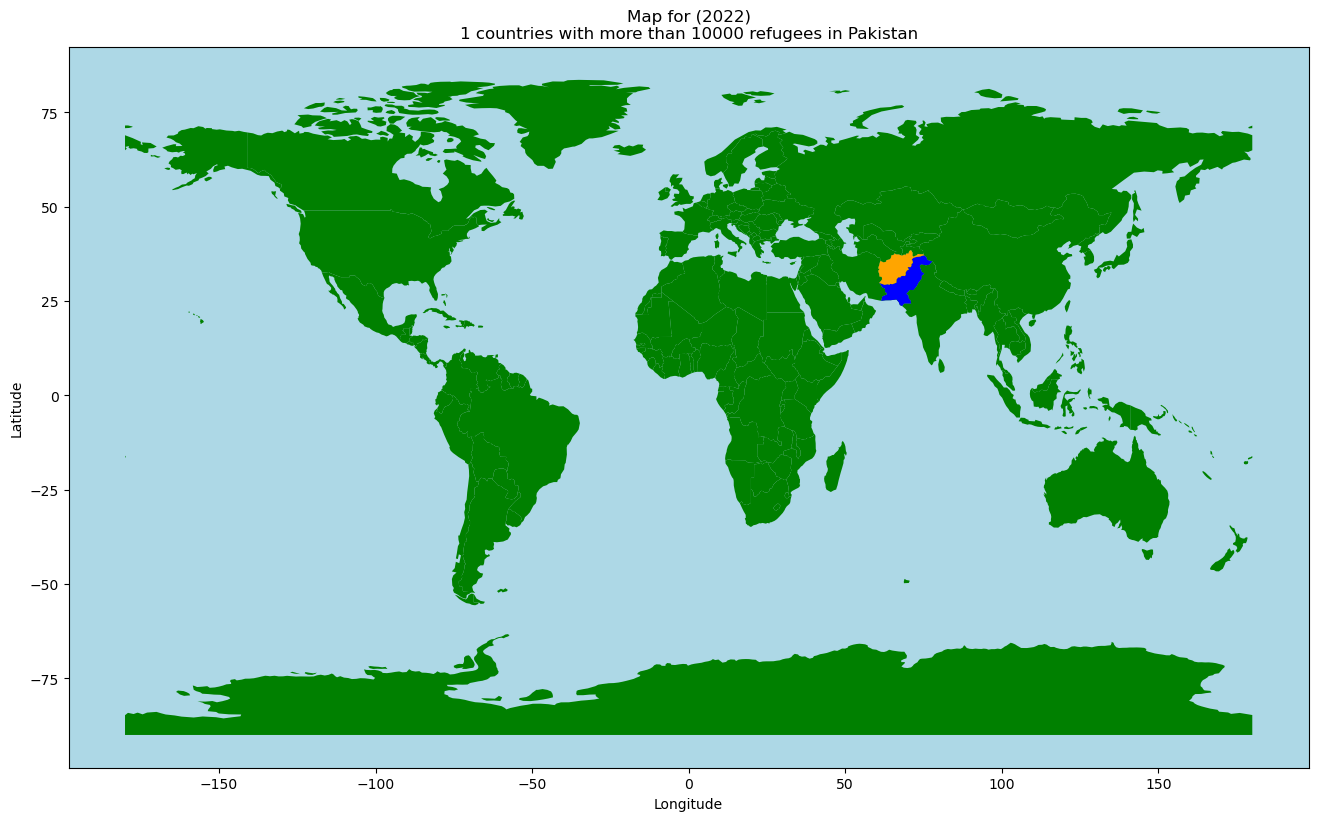

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1283298436.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


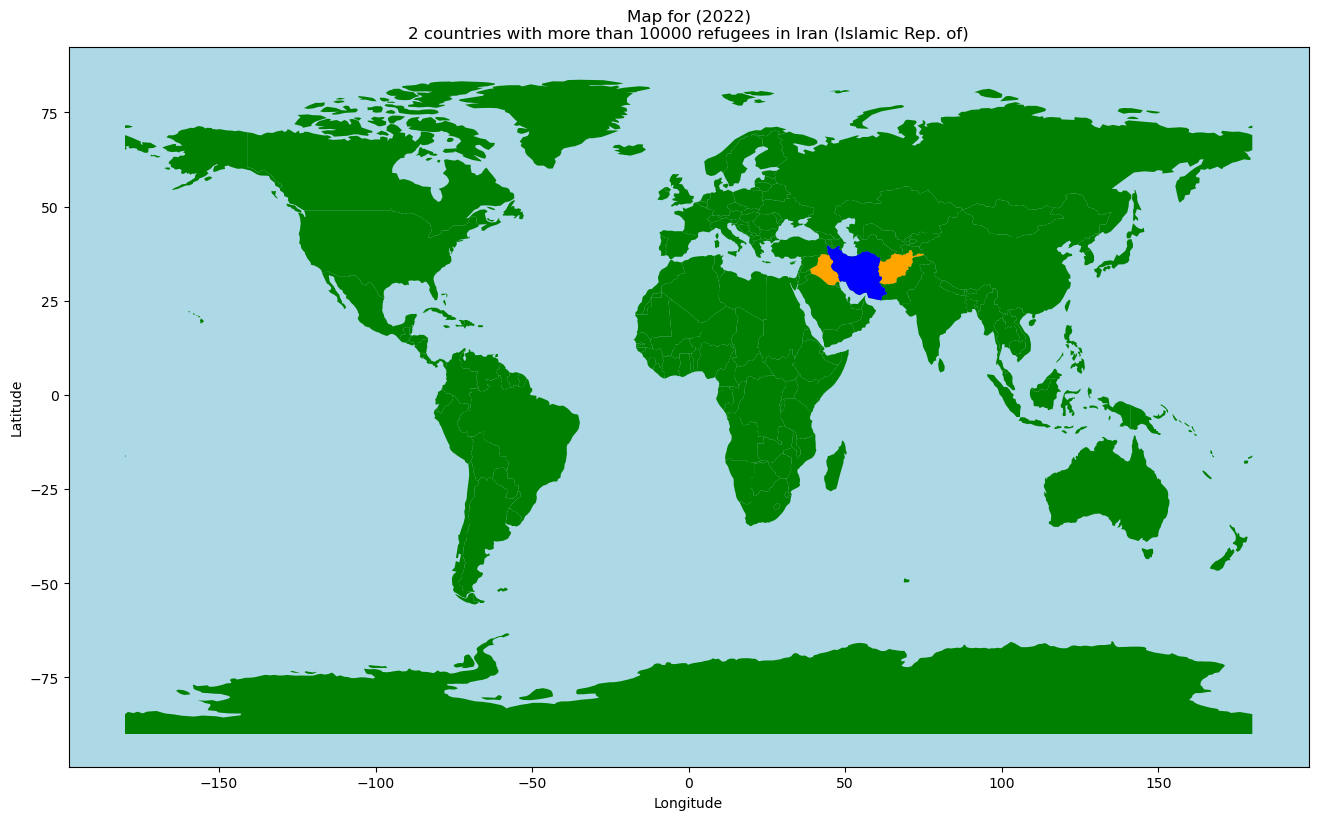

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1283298436.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


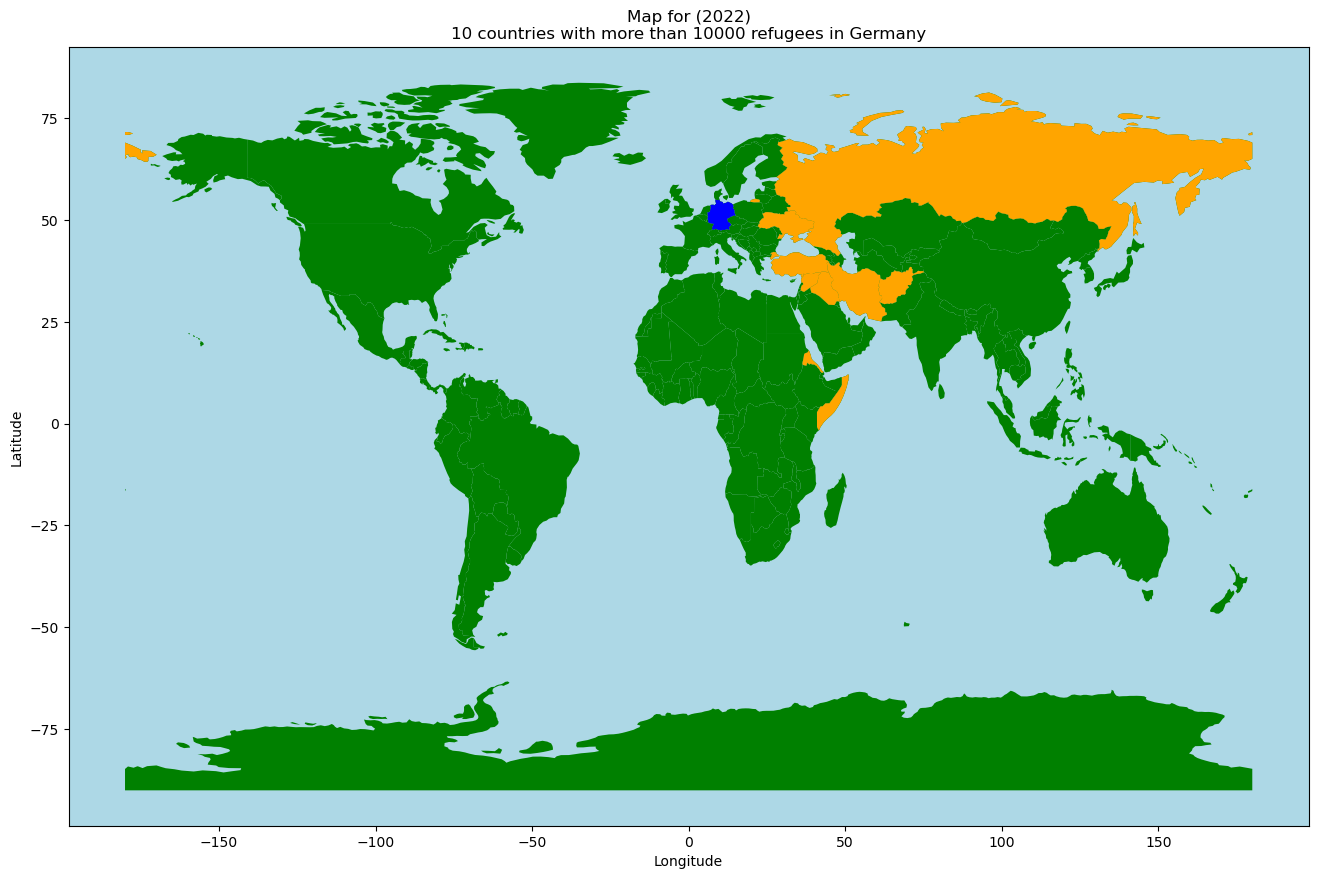

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1283298436.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


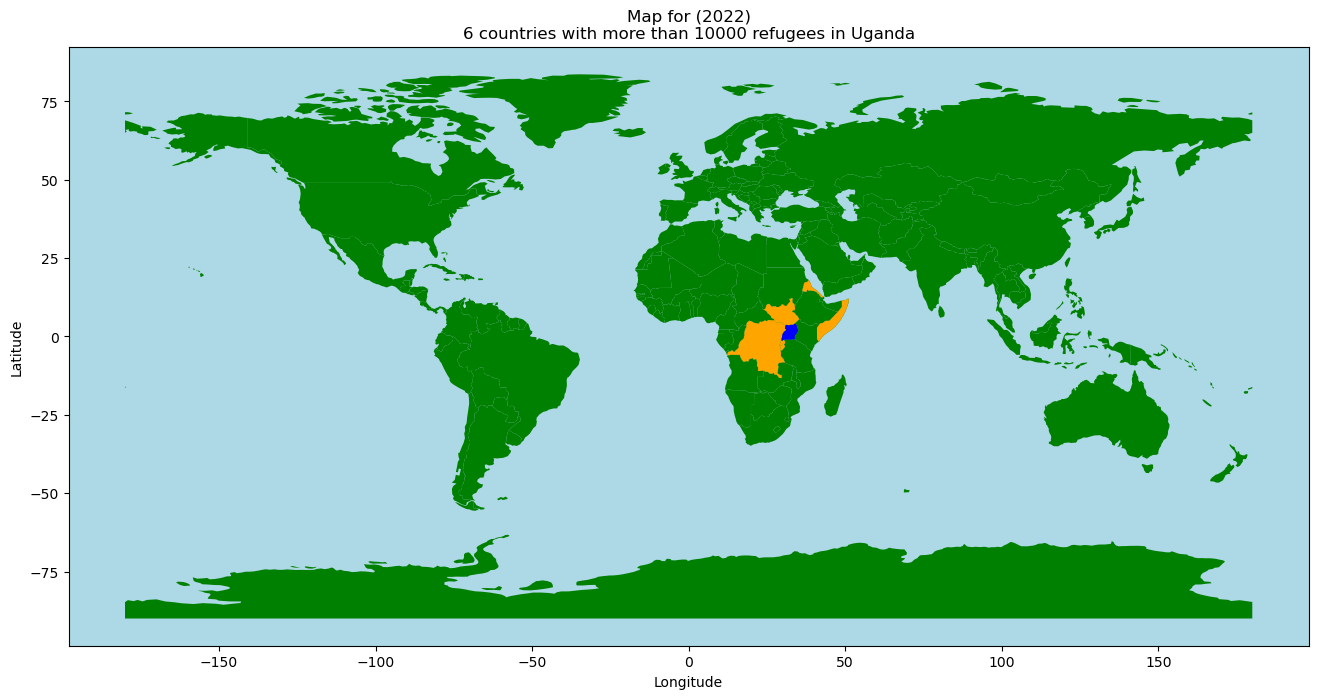

In [44]:
COUNTRY_OF_ASLYM_ISO = ["TUR", "PAK", "IRN", "DEU", "UGA"]

for country in COUNTRY_OF_ASLYM_ISO:
    filtered_data_2018_2022_aslym = un_refuges_data[(un_refuges_data["Country of asylum (ISO)"] == country)]
    create_map_for_country_aslym(filtered_data_2018_2022_aslym)

### You can use this dataset to find countries by name and ISO 3166-1 alpha-3

In [45]:
countries_and_iso = un_refuges_data[["Country of origin", "Country of origin (ISO)"]]

countries_and_iso = countries_and_iso.drop_duplicates()
countries_and_iso = countries_and_iso.reset_index()
countries_and_iso = countries_and_iso.drop(columns= "index")
countries_and_iso = countries_and_iso.rename(columns = {"Country of origin": "Country", "Country of origin (ISO)": "Country_ISO" })
countries_and_iso.head()

Country Country_ISO
0             Afghanistan         AFG
1              Bangladesh         BGD
2  Iran (Islamic Rep. of)         IRN
3                Pakistan         PAK
4              Tajikistan         TJK

In [46]:
countries_and_iso[countries_and_iso.Country == "Switzerland"]

Country Country_ISO
193  Switzerland         CHE

In [47]:
countries_and_iso[countries_and_iso.Country_ISO == "NLD"]

Country Country_ISO
128  Netherlands (Kingdom of the)         NLD

### Now, you can view a map of where refugees are going by entering the name of country and year between 2018-2022 and refugees treshhold.

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\3509060962.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


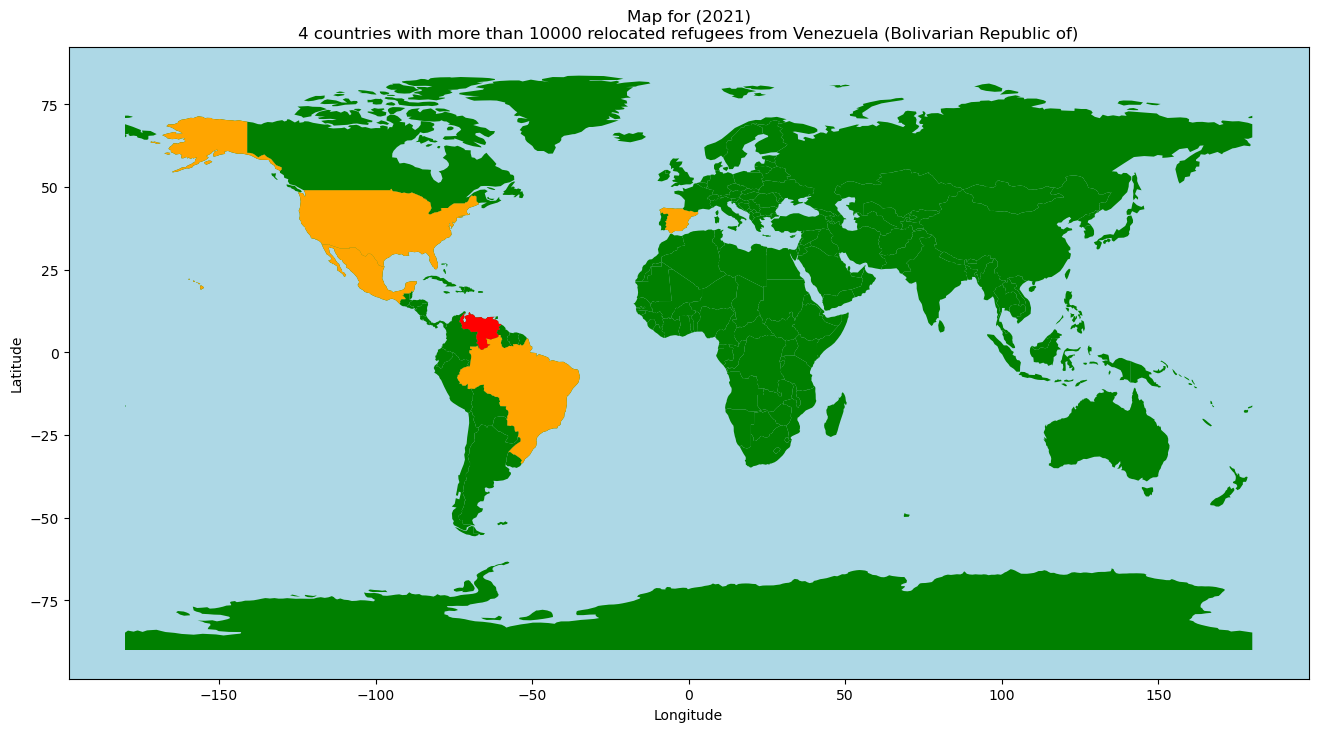

In [48]:
COUNTRY_ORIGIN = "Somalia"
COUNTRY_ORIGIN = "Mexico"
COUNTRY_ORIGIN = "Venezuela (Bolivarian Republic of)"
# COUNTRY_ORIGIN = "China"
year = 2021
refugees_treshhold = 10_000
filtered_data_2018_2022_aslym = un_refuges_data[(un_refuges_data["Country of origin"] == COUNTRY_ORIGIN)]
create_map_for_country_refugee(filtered_data_2018_2022_aslym, year, refugees_treshhold)

### You can also view a map of refugees arriving in country of asylum by entering the name of that country and year between 2018-2022 and refugees treshhold.

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1283298436.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


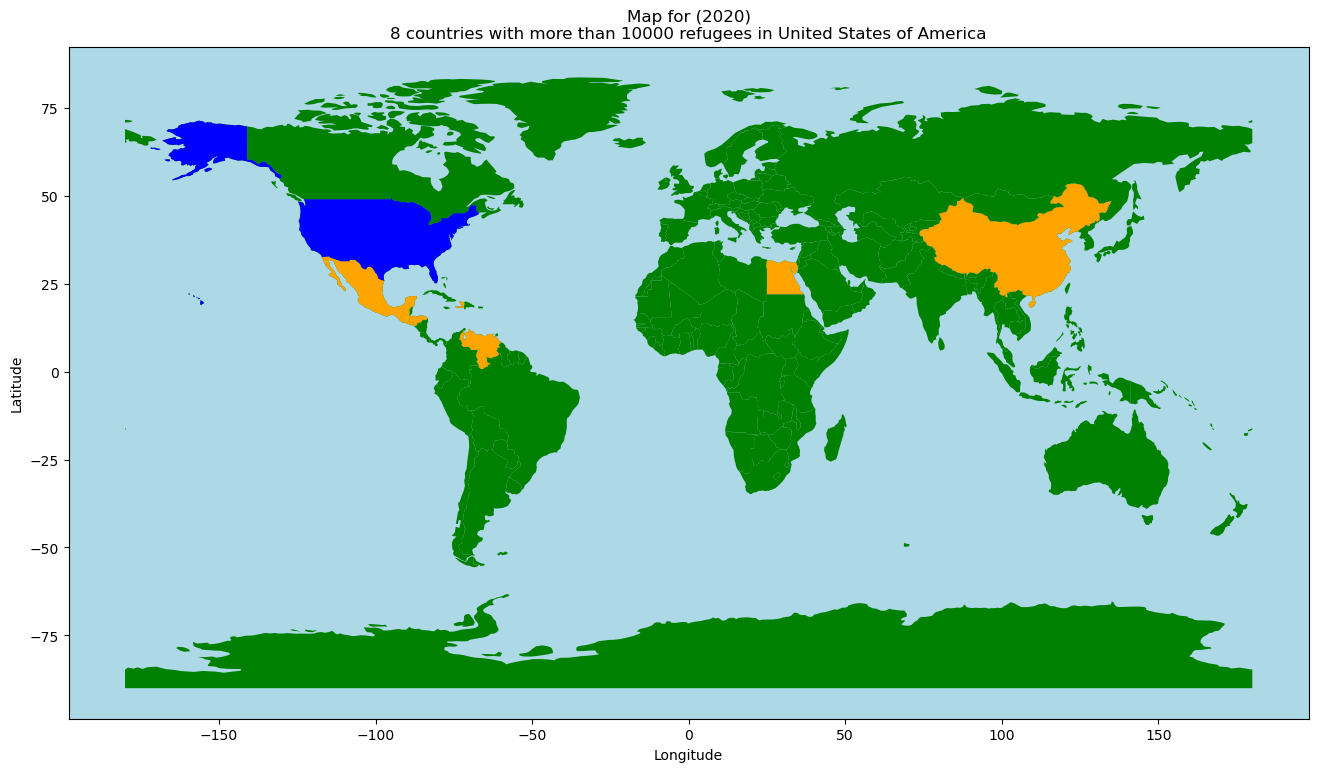

In [49]:
COUNTRY_ASLYM = "United States of America"
# COUNTRY_ASLYM = "Switzerland"
# COUNTRY_ASLYM = "United Kingdom of Great Britain and Northern Ireland"
# COUNTRY_ASLYM = "Bulgaria"
# COUNTRY_ASLYM = "Romania"
# COUNTRY_ASLYM = "Serbia and Kosovo: S/RES/1244 (1999)"
year = 2020
refugees_treshhold = 10_000
filtered_data_2018_2022_aslym = un_refuges_data[(un_refuges_data["Country of asylum"] == COUNTRY_ASLYM)]
create_map_for_country_aslym(filtered_data_2018_2022_aslym, year, refugees_treshhold)

## III. Refugee flows and EU

In [50]:
eu_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", 
    "Czechia", "Denmark", "Estonia", "Finland", 
    "France", "Germany", "Greece", "Hungary", "Ireland", 
    "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", 
    "Netherlands (Kingdom of the)", "Poland", "Portugal", "Romania", 
    "Slovakia", "Slovenia", "Spain", "Sweden"
]
un_refuges_data_2022 = un_refuges_data[un_refuges_data["Year"] == 2022]
un_refuges_in_EU_data_2022 = un_refuges_data_2022[un_refuges_data["Country of asylum"].isin(eu_countries)]
combined_data_for_EU_asylum = un_refuges_in_EU_data_2022.copy()
un_refuges_in_EU_data_2022.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1574449014.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  un_refuges_in_EU_data_2022 = un_refuges_data_2022[un_refuges_data["Country of asylum"].isin(eu_countries)]


Year Country of origin Country of origin (ISO) Country of asylum  \
95374  2022       Afghanistan                     AFG           Austria   
95375  2022           Albania                     ALB           Austria   
95376  2022           Algeria                     DZA           Austria   
95377  2022            Angola                     AGO           Austria   
95378  2022             Egypt                     EGY           Austria   

      Country of asylum (ISO)  Refugees under UNHCR's mandate  
95374                     AUT                           45282  
95375                     AUT                              49  
95376                     AUT                              27  
95377                     AUT                              36  
95378                     AUT                             221

In [51]:
un_refuges_in_EU_data_2022 = pd.DataFrame(un_refuges_in_EU_data_2022.groupby("Country of asylum")["Refugees under UNHCR's mandate"].sum())
un_refuges_in_EU_data_2022 = un_refuges_in_EU_data_2022.reset_index()
un_refuges_in_EU_data_2022 = un_refuges_in_EU_data_2022.rename(columns={"Country of asylum": "country", "Refugees under UNHCR's mandate": "refugees"})
un_refuges_in_EU_data_2022["country"] = un_refuges_in_EU_data_2022["country"].replace("Netherlands (Kingdom of the)", "Netherlands")
un_refuges_in_EU_data_2022["country"] = un_refuges_in_EU_data_2022["country"].replace("Czechia", "Czech Republic")
un_refuges_in_EU_data_2022

country  refugees
0          Austria    258613
1          Belgium    151408
2         Bulgaria    176297
3          Croatia     20638
4           Cyprus     29280
5   Czech Republic    435212
6          Denmark     67772
7          Estonia     40806
8          Finland     69553
9           France    612934
10         Germany   2075445
11          Greece    160761
12         Hungary     35370
13         Ireland     81256
14           Italy    296181
15          Latvia     39055
16       Lithuania     67638
17      Luxembourg     11952
18           Malta     11098
19     Netherlands    218457
20          Poland    971129
21        Portugal     59777
22         Romania    105621
23        Slovakia     96563
24        Slovenia      8705
25           Spain    317751
26          Sweden    277726

In [52]:
combined_data_for_EU_asylum["Country of asylum"] = "European Union"
combined_data_for_EU_asylum["Country of asylum (ISO)"] = "EU"
combined_data_for_EU_asylum.head()


Year Country of origin Country of origin (ISO) Country of asylum  \
95374  2022       Afghanistan                     AFG    European Union   
95375  2022           Albania                     ALB    European Union   
95376  2022           Algeria                     DZA    European Union   
95377  2022            Angola                     AGO    European Union   
95378  2022             Egypt                     EGY    European Union   

      Country of asylum (ISO)  Refugees under UNHCR's mandate  
95374                      EU                           45282  
95375                      EU                              49  
95376                      EU                              27  
95377                      EU                              36  
95378                      EU                             221

In [53]:
combined_data_for_EU_asylum = pd.DataFrame(combined_data_for_EU_asylum.groupby("Country of origin")["Refugees under UNHCR's mandate"].sum())
total_refugees_EU_2022 = combined_data_for_EU_asylum["Refugees under UNHCR's mandate"].sum()
print(f"There are {total_refugees_EU_2022} people from {combined_data_for_EU_asylum.shape[0]} countries for 2022")
percent_refugees_from_ukraine = combined_data_for_EU_asylum[combined_data_for_EU_asylum.index == "Ukraine"] / total_refugees_EU_2022  * 100
print(percent_refugees_from_ukraine)

There are 6696998 people from 170 countries for 2022
                   Refugees under UNHCR's mandate
Country of origin                                
Ukraine                                 57.553877


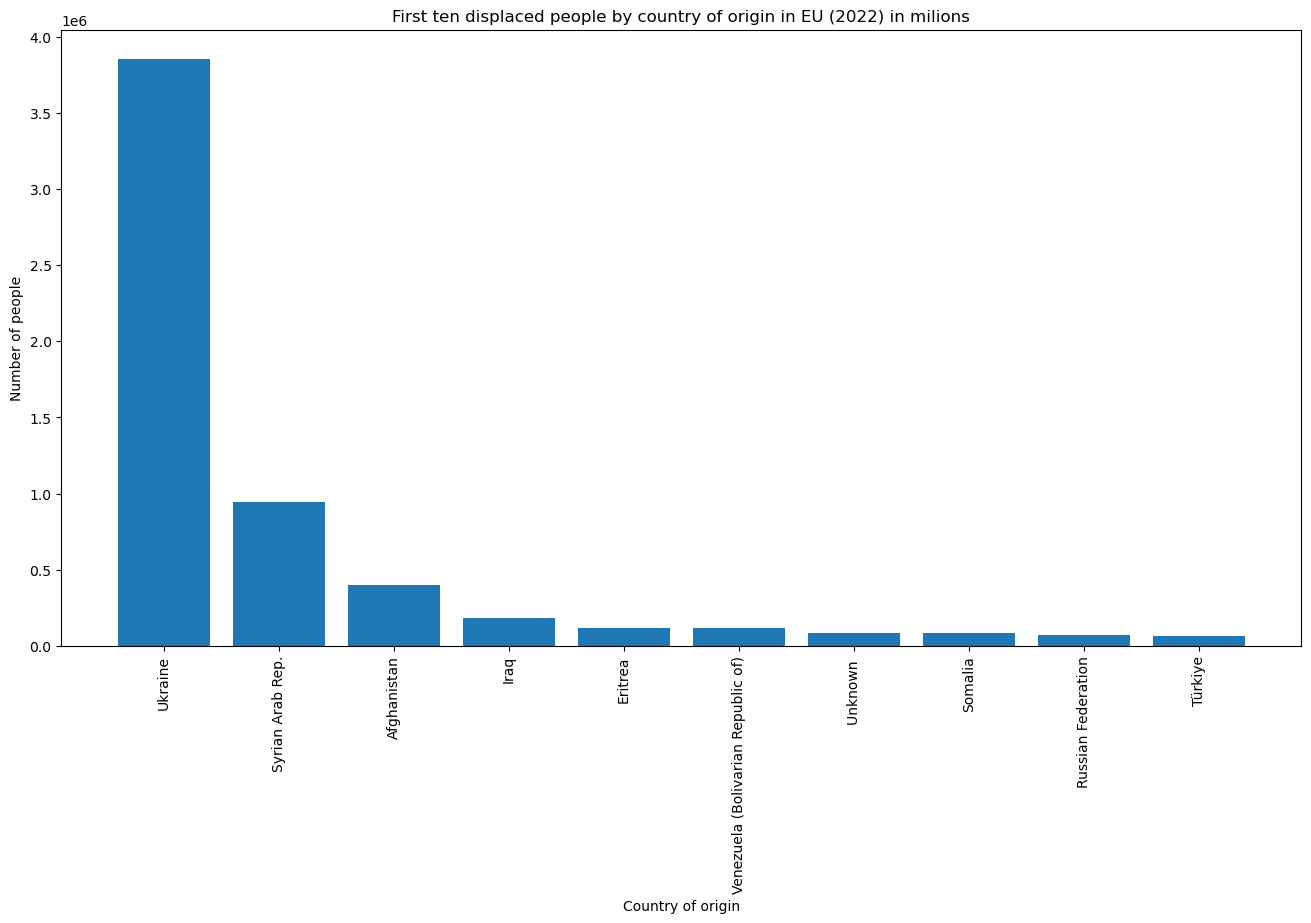

In [54]:
combined_data_for_EU_asylum = combined_data_for_EU_asylum.nlargest(10, "Refugees under UNHCR's mandate")

plt.figure(figsize=(16, 8))

plt.bar(combined_data_for_EU_asylum.index, combined_data_for_EU_asylum["Refugees under UNHCR's mandate"])

plt.xlabel('Country of origin')
plt.ylabel('Number of people')
plt.title(f'First ten displaced people by country of origin in EU (2022) in milions')
plt.xticks(rotation=90) 
plt.show()

57.55% of refugees in Europe for 2022 are from Ukraine

In [55]:
url = "https://en.wikipedia.org/wiki/Demographics_of_the_European_Union"
tables = pd.read_html(url, header=0)

EU_data_population = tables[1]
EU_data_population = EU_data_population[["Member State", "Population"]]
EU_data_population = EU_data_population.rename(columns={"Member State": "country", "Population": "population"})

file_path = os.path.join("data/eu_data", "eu_data.csv")
EU_data_population.to_csv(file_path, index=False)

In [56]:
EU_data_population = pd.read_csv("data/eu_data/eu_data.csv")
EU_data_population = EU_data_population.drop(0)
EU_data_population = EU_data_population.reset_index(drop=True)
EU_data_population.head()

country  population
0   Austria     9104772
1   Belgium    11754004
2  Bulgaria     6447710
3   Croatia     3850894
4    Cyprus      920701

In [57]:
EU_data_population_with_refugees = pd.merge(EU_data_population, un_refuges_in_EU_data_2022, left_on='country', right_on='country')
EU_data_population_with_refugees.head()

country  population  refugees
0   Austria     9104772    258613
1   Belgium    11754004    151408
2  Bulgaria     6447710    176297
3   Croatia     3850894     20638
4    Cyprus      920701     29280

In [58]:
EU_data_population_with_refugees["percent_of_population_refugees"] = EU_data_population_with_refugees["refugees"] / EU_data_population_with_refugees["population"] * 100
EU_data_population_with_refugees

country  population  refugees  percent_of_population_refugees
0          Austria     9104772    258613                        2.840412
1          Belgium    11754004    151408                        1.288140
2         Bulgaria     6447710    176297                        2.734258
3          Croatia     3850894     20638                        0.535928
4           Cyprus      920701     29280                        3.180186
5   Czech Republic    10827529    435212                        4.019495
6          Denmark     5932654     67772                        1.142356
7          Estonia     1365884     40806                        2.987516
8          Finland     5563970     69553                        1.250061
9           France    68070697    612934                        0.900437
10         Germany    84358845   2075445                        2.460258
11          Greece    10394055    160761                        1.546663
12         Hungary     9597085     35370                        0.368549
13         Ireland     5194336     81256                        1.564319
14           Italy    58850717    296181                        0.503275
15          Latvia     1883008     39055                        2.074075
16       Lithuania     2857279     67638                        2.367217
17      Luxembourg      660809     11952                        1.808692
18           Malta      542051     11098                        2.047409
19     Netherlands    17811291    218457                        1.226509
20          Poland    36753736    971129                        2.642259
21        Portugal    10467366     59777                        0.571080
22         Romania    19051562    105621                        0.554395
23        Slovakia     5428792     96563                        1.778720
24        Slovenia     2116792      8705                        0.411235
25           Spain    48059777    317751                        0.661158
26          Sweden    10521556    277726                        2.639591

In [59]:
percent_refugees_in_EU = EU_data_population_with_refugees["refugees"].sum() / EU_data_population_with_refugees["population"].sum() * 100
number_refugees_in_EU = EU_data_population_with_refugees["refugees"].sum()
print(f"{number_refugees_in_EU} refugees or {percent_refugees_in_EU:.2f}% of EU population")

6696998 refugees or 1.49% of EU population


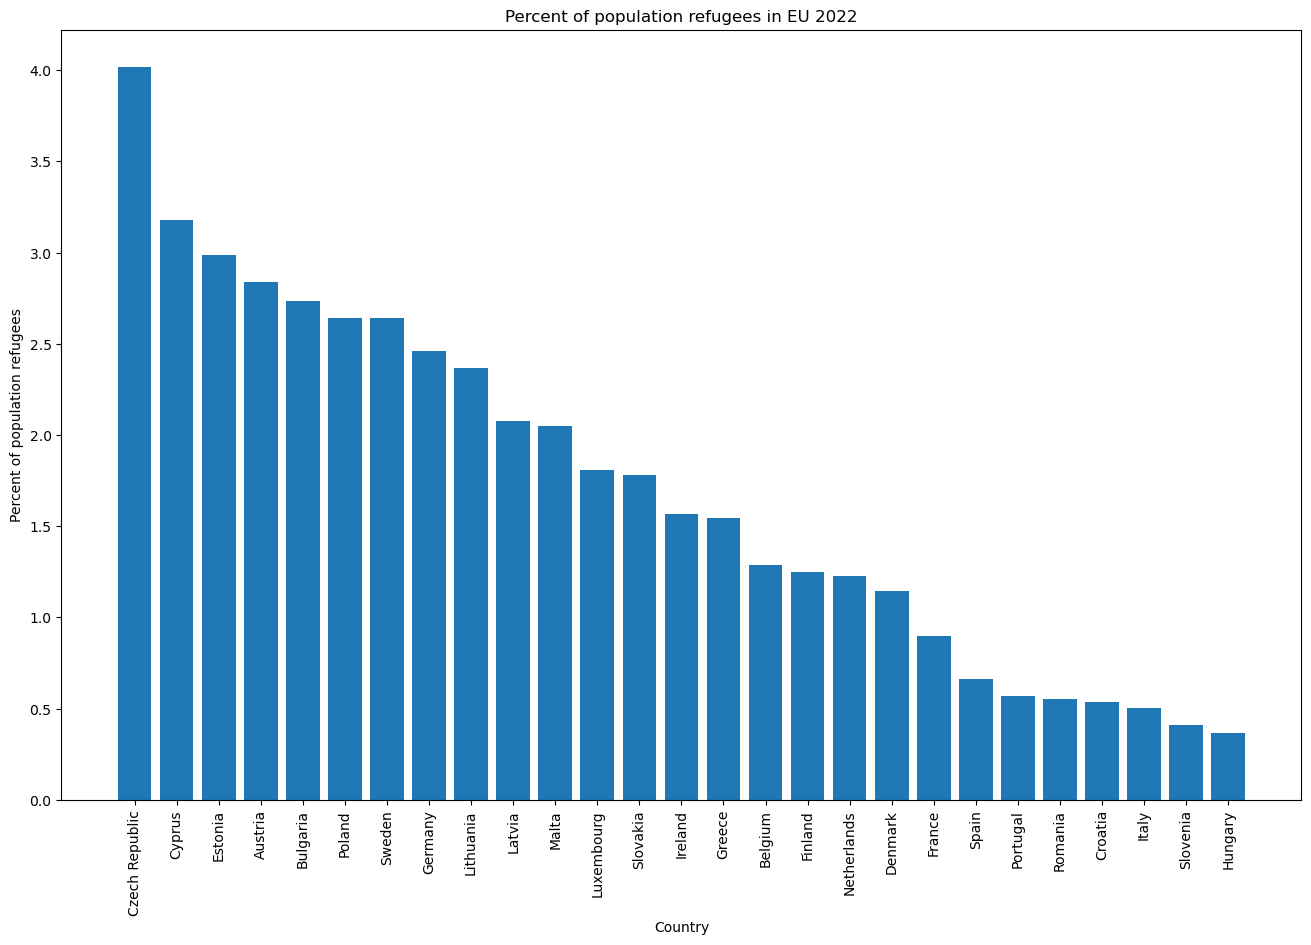

In [60]:
EU_data_population_with_refugees_sorted = EU_data_population_with_refugees.sort_values(by="percent_of_population_refugees", ascending=False)
plt.figure(figsize=(16, 10)) 

plt.bar(EU_data_population_with_refugees_sorted['country'], EU_data_population_with_refugees_sorted['percent_of_population_refugees'])

plt.xlabel('Country')
plt.ylabel('Percent of population refugees')
plt.title('Percent of population refugees in EU 2022')
plt.xticks(rotation=90) 

plt.show()

Earlier we examined that Germany is first by number of refugees asylum in the EU. In reality, we see that the Czech Republic has a significantly larger number as a percentage of the population. We note that the difference between the country with the most refugees (Czech Republic) and the country with the fewest (Hungary) is around 3.50%.

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1283298436.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


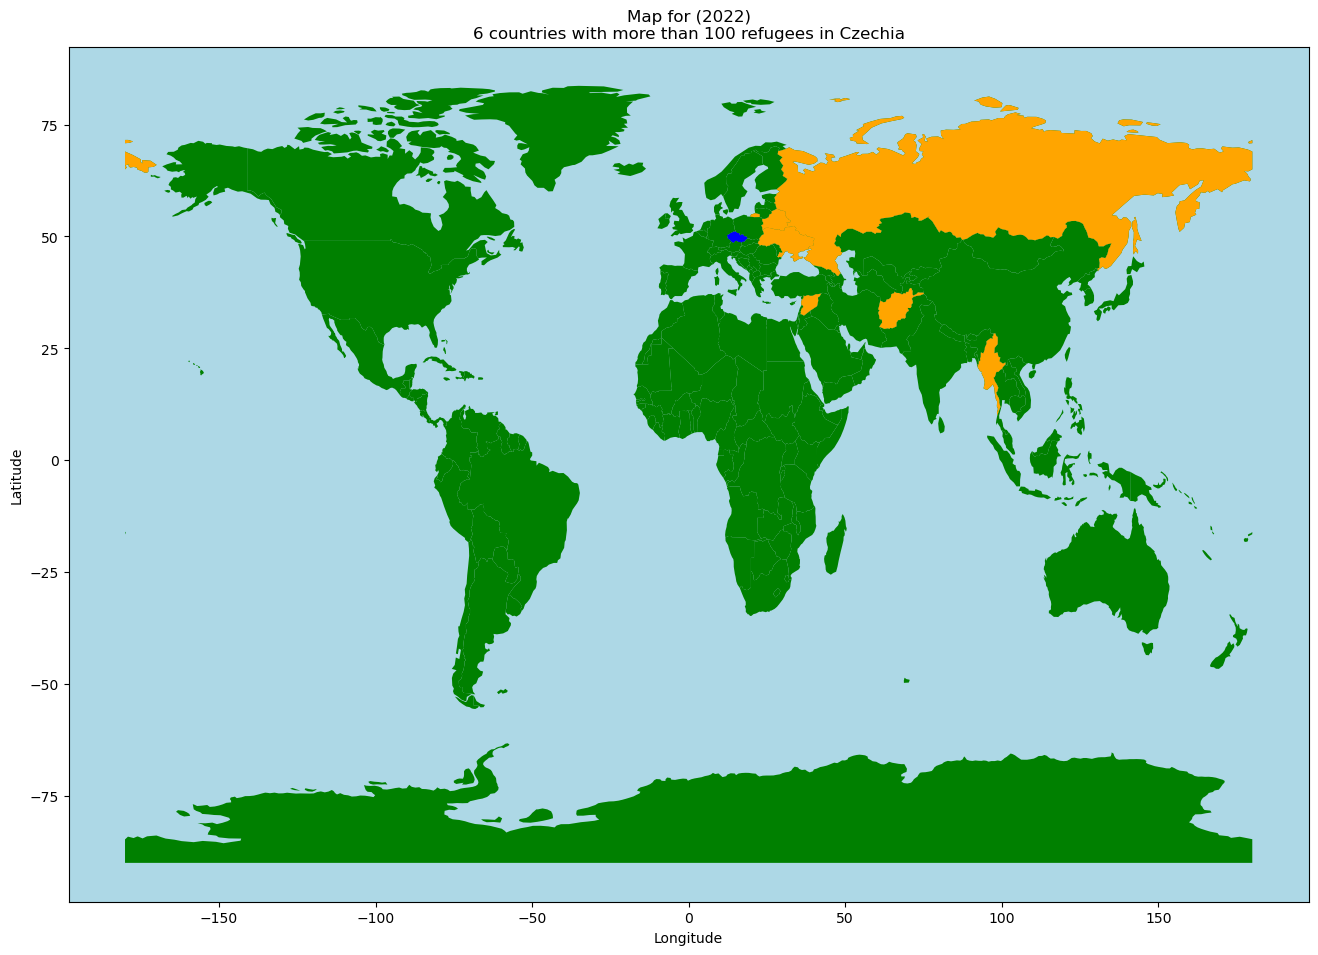

In [61]:
COUNTRY_ASLYM = "Czechia"
year = 2022
refugees_treshhold = 100
filtered_data_2018_2022_aslym = un_refuges_data[(un_refuges_data["Country of asylum"] == COUNTRY_ASLYM)]
create_map_for_country_aslym(filtered_data_2018_2022_aslym, year, refugees_treshhold)

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1283298436.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


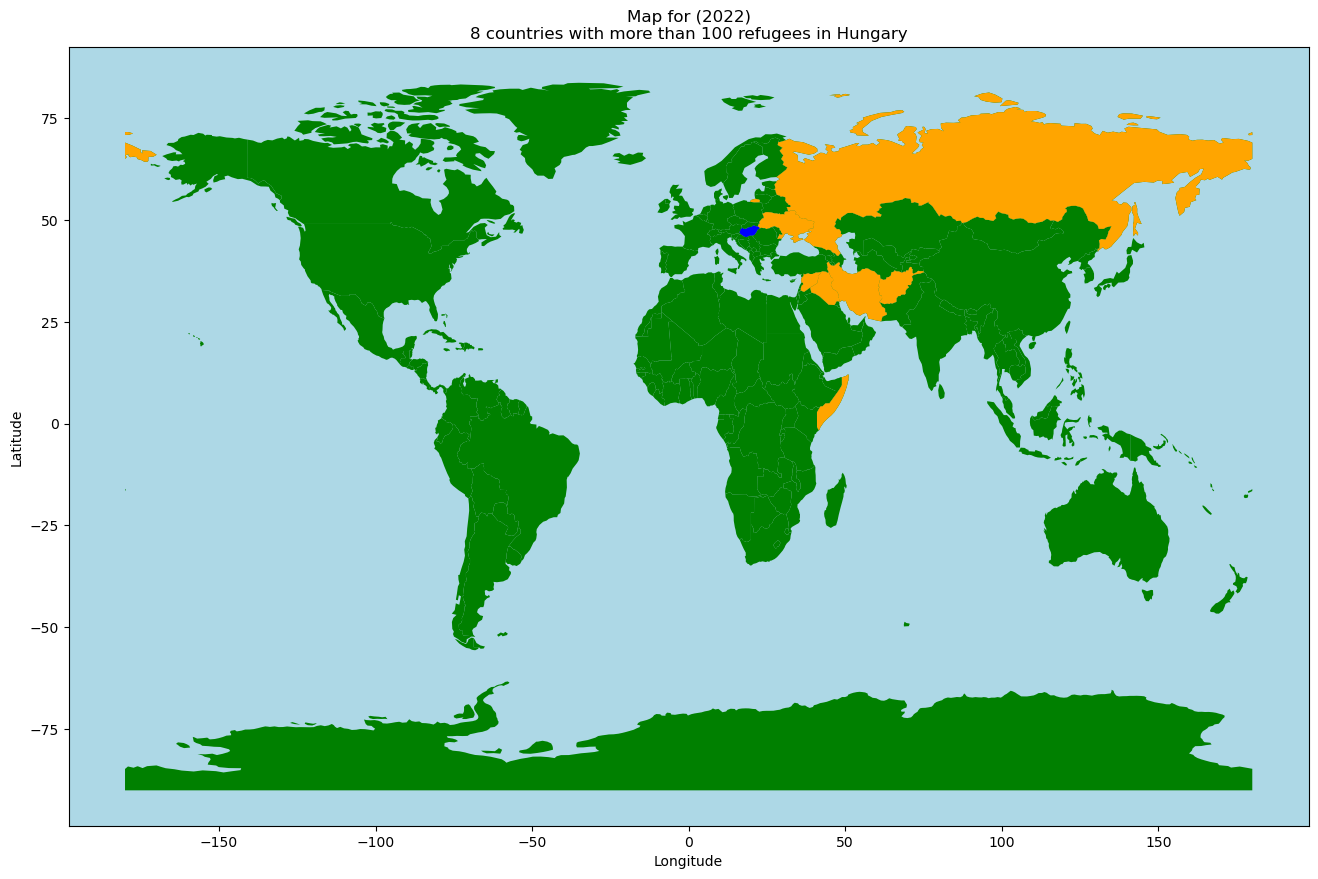

In [62]:
COUNTRY_ASLYM = "Hungary"
year = 2022
refugees_treshhold = 100
filtered_data_2018_2022_aslym = un_refuges_data[(un_refuges_data["Country of asylum"] == COUNTRY_ASLYM)]
create_map_for_country_aslym(filtered_data_2018_2022_aslym, year, refugees_treshhold)

It's interesting to see which parties are in power and what their political beliefs are. In Czech Republic - Centrist to centre-right and populist political party, while in Hungary - Right-wing to far-right.

In [63]:
# hdi_data = pd.read_excel("data/human_development_index/HDI_Trends_Table.xlsx",skiprows=[1])
# hdi_data = hdi_data[0:196]
# hdi_data.columns = [str(col) for col in hdi_data.columns]
# hdi_data = hdi_data.drop(columns=["1990", "2000", "2010", "2015"])
# hdi_data.head()

### IV. Comparing UNHCR's Global Trends Reports for 2021 and 2022

We will try to conduct a very basic, fundamental analysis and comparison of the key terms in the UNHCR's Global Trends Reports for 2021 and 2022.

In [64]:
# with open('pdfs/global-trends-report-2022.pdf', 'rb') as file:
#     pdf_reader = PyPDF2.PdfReader(file)
#     num_pages = len(pdf_reader.pages)
#     extracted_text = ""

#     for page_num in range(num_pages):
#         page = pdf_reader.pages[page_num]
#         extracted_text += page.extract_text()

# with open('text/global-trends-report-2022.txt', 'w', encoding='utf-8') as text_file:
#     text_file.write(extracted_text)

In [65]:
with open('text/global-trends-report-2021.txt', 'r', encoding='utf-8') as file:
    content_trend_report_2021 = file.read()

with open('text/global-trends-report-2022.txt', 'r', encoding='utf-8') as file:
    content_trend_report_2022 = file.read()

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform([content_trend_report_2021, content_trend_report_2022])

scores_2021 = X.toarray()[0]
scores_2022 = X.toarray()[1]

word_scores_2021 = dict(zip(vectorizer.get_feature_names_out(), scores_2021))
word_scores_2022 = dict(zip(vectorizer.get_feature_names_out(), scores_2022))

sorted_word_scores_2021 = dict(sorted(word_scores_2021.items(), key=lambda item: item[1], reverse=True)[:20])
sorted_word_scores_2022 = dict(sorted(word_scores_2022.items(), key=lambda item: item[1], reverse=True)[:20])

print("2021 top 20 words:")
for word, score in sorted_word_scores_2021.items():
    print(f"{word}: {score}")

print("\n2022 top 20 words:")
for word, score in sorted_word_scores_2022.items():
    print(f"{word}: {score}")


global_trends_report_2021_2022 = pd.DataFrame({
    'words_2021': pd.Series(word_scores_2021),
    'words_2022': pd.Series(word_scores_2022)
})
global_trends_report_2021_2022 = global_trends_report_2021_2022.sort_values(by=["words_2021", "words_2022"], ascending=False)
global_trends_report_2021_2022


2021 top 20 words:
unhcr: 0.2853984828244963
2021: 0.27565316877683055
refugees: 0.2645156670080697
displaced: 0.2589469161236893
people: 0.2464172266338334
million: 0.22831878625959703
countries: 0.20047503183769497
per: 0.19212190551112432
000: 0.1893375300689341
cent: 0.1809844037423635
country: 0.1433953352727957
refugee: 0.1433953352727957
asylum: 0.13225783350403486
global: 0.13225783350403486
year: 0.12668908261965445
population: 0.11555158085089362
number: 0.107198454524323
see: 0.10302189136103769
data: 0.09884532819775237
displacement: 0.09884532819775237

2022 top 20 words:
refugees: 0.2988649490827937
people: 0.28120474754608316
2022: 0.27577083938094143
unhcr: 0.2526767296790892
million: 0.2472428215139475
countries: 0.24452586743137664
per: 0.23365805110109325
cent: 0.21871480364695356
asylum: 0.14943247454139685
000: 0.146715520458826
displaced: 0.14128161229368427
protection: 0.13856465821111344
refugee: 0.13041379596340089
number: 0.1209044566744029
country: 0.11547054

words_2021  words_2022
unhcr        0.285398    0.252677
2021         0.275653    0.073358
refugees     0.264516    0.298865
displaced    0.258947    0.141282
people       0.246417    0.281205
...               ...         ...
wounded      0.000000    0.001909
xlsx         0.000000    0.001909
year15       0.000000    0.001909
yearsin      0.000000    0.001909
zip          0.000000    0.001909

[3369 rows x 2 columns]

In [66]:
global_trends_report_2021_2022.corr()

words_2021  words_2022
words_2021    1.000000    0.868362
words_2022    0.868362    1.000000

We observe a similarity in the content of the reports from two different years of about 87%. We cannot conclude whether this is a minor difference. Therefore, let's show the frequency of usage of various words, and let the reader determine this themselves.

In [67]:
wc = WordCloud(width=800, height=400, 
               background_color='white',
               stopwords=stopwords.words('english'),
               min_font_size=10)

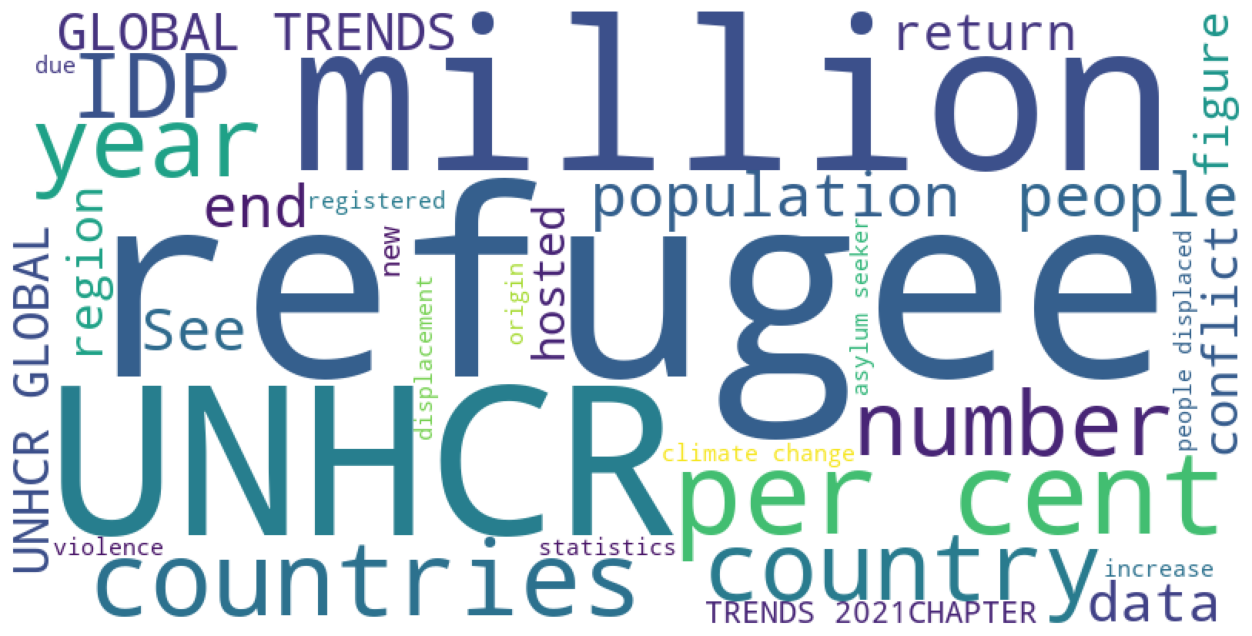

In [68]:
wc_plot_2021 = wc.generate(content_trend_report_2021)

plt.figure(figsize=(16, 8))
plt.imshow(wc_plot_2021)
plt.axis("off")
plt.show()

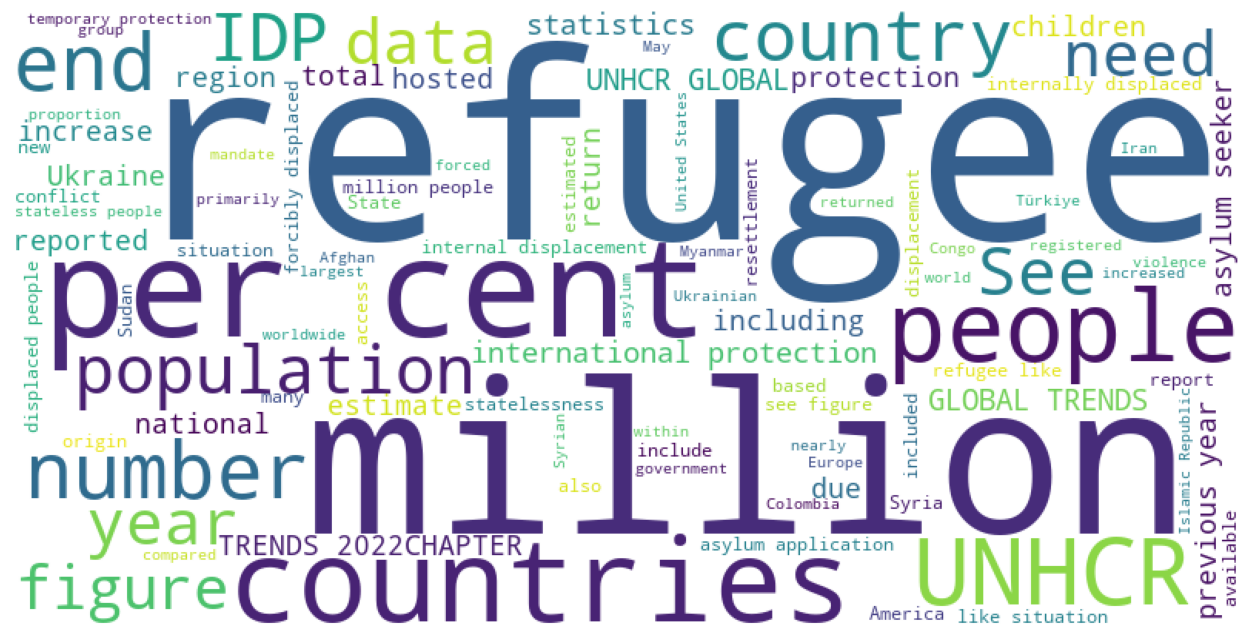

In [69]:
wc_plot_2022 = wc.generate(content_trend_report_2022)

plt.figure(figsize=(16, 8))
plt.imshow(wc_plot_2022)
plt.axis("off")
plt.show()

### Conclusion

As we saw in our study, Earth is not such a peaceful place. Refugee flows and their increasing trend have and will continue to have a significant impact on the demographic map of the world. In conclusion, we can say that if there is a major military conflict, we can expect new waves of refugees.